In [1]:
import numpy as np
from polars import DataFrame
from requests.packages import target
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from statsmodels.stats._adnorm import normal_ad

from data_loader import load_data
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

## Loading data

In [2]:
load_data("shivachandel/kc-house-data", "../Data")
df = pl.read_csv("../Data/kc_house_data.csv", try_parse_dates=True)

Dataset URL: https://www.kaggle.com/datasets/shivachandel/kc-house-data


## Data exploration

In [3]:
df.head()

shape: (5, 21)
┌────────────┬────────────┬──────────┬──────────┬───┬─────────┬──────────┬────────────┬────────────┐
│ id         ┆ date       ┆ price    ┆ bedrooms ┆ … ┆ lat     ┆ long     ┆ sqft_livin ┆ sqft_lot15 │
│ ---        ┆ ---        ┆ ---      ┆ ---      ┆   ┆ ---     ┆ ---      ┆ g15        ┆ ---        │
│ i64        ┆ str        ┆ f64      ┆ i64      ┆   ┆ f64     ┆ f64      ┆ ---        ┆ i64        │
│            ┆            ┆          ┆          ┆   ┆         ┆          ┆ i64        ┆            │
╞════════════╪════════════╪══════════╪══════════╪═══╪═════════╪══════════╪════════════╪════════════╡
│ 7129300520 ┆ 20141013T0 ┆ 221900.0 ┆ 3        ┆ … ┆ 47.5112 ┆ -122.257 ┆ 1340       ┆ 5650       │
│            ┆ 00000      ┆          ┆          ┆   ┆         ┆          ┆            ┆            │
│ 6414100192 ┆ 20141209T0 ┆ 538000.0 ┆ 3        ┆ … ┆ 47.721  ┆ -122.319 ┆ 1690       ┆ 7639       │
│            ┆ 00000      ┆          ┆          ┆   ┆         ┆          ┆            ┆            │
│ 5631500400 ┆ 20150225T0 ┆ 180000.0 ┆ 2        ┆ … ┆ 47.7379 ┆ -122.233 ┆ 2720       ┆ 8062       │
│            ┆ 00000      ┆          ┆          ┆   ┆         ┆          ┆            ┆            │
│ 2487200875 ┆ 20141209T0 ┆ 604000.0 ┆ 4        ┆ … ┆ 47.5208 ┆ -122.393 ┆ 1360       ┆ 5000       │
│            ┆ 00000      ┆          ┆          ┆   ┆         ┆          ┆            ┆            │
│ 1954400510 ┆ 20150218T0 ┆ 510000.0 ┆ 3        ┆ … ┆ 47.6168 ┆ -122.045 ┆ 1800       ┆ 7503       │
│            ┆ 00000      ┆          ┆          ┆   ┆         ┆          ┆            ┆            │
└────────────┴────────────┴──────────┴──────────┴───┴─────────┴──────────┴────────────┴────────────┘

In [4]:
df.describe()

shape: (9, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ id        ┆ date      ┆ price     ┆ … ┆ lat       ┆ long      ┆ sqft_livi ┆ sqft_lot │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ng15      ┆ 15       │
│ str       ┆ f64       ┆ str       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 21613.0   ┆ 21613     ┆ 21613.0   ┆ … ┆ 21613.0   ┆ 21613.0   ┆ 21613.0   ┆ 21613.0  │
│ null_coun ┆ 0.0       ┆ 0         ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 4.5803e9  ┆ null      ┆ 540088.14 ┆ … ┆ 47.560053 ┆ -122.2138 ┆ 1986.5524 ┆ 12768.45 │
│           ┆           ┆           ┆ 1767      ┆   ┆           ┆ 96        ┆ 92        ┆ 5652     │
│ std       ┆ 2.8766e9  ┆ null      ┆ 367127.19 ┆ … ┆ 0.138564  ┆ 0.140828  ┆ 685.39130 ┆ 27304.17 │
│           ┆           ┆           ┆ 6483      ┆   ┆           ┆           ┆ 4         ┆ 9631     │
│ min       ┆ 1.000102e ┆ 20140502T ┆ 75000.0   ┆ … ┆ 47.1559   ┆ -122.519  ┆ 399.0     ┆ 651.0    │
│           ┆ 6         ┆ 000000    ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ 2.1230e9  ┆ null      ┆ 321950.0  ┆ … ┆ 47.471    ┆ -122.328  ┆ 1490.0    ┆ 5100.0   │
│ 50%       ┆ 3.9049e9  ┆ null      ┆ 450000.0  ┆ … ┆ 47.5718   ┆ -122.23   ┆ 1840.0    ┆ 7620.0   │
│ 75%       ┆ 7.3089e9  ┆ null      ┆ 645000.0  ┆ … ┆ 47.678    ┆ -122.125  ┆ 2360.0    ┆ 10083.0  │
│ max       ┆ 9.9000e9  ┆ 20150527T ┆ 7.7e6     ┆ … ┆ 47.7776   ┆ -121.315  ┆ 6210.0    ┆ 871200.0 │
│           ┆           ┆ 000000    ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [5]:
df = df.with_columns(pl.col("date").str.strptime(pl.Date, "%Y%m%dT%H%M%S"))
df = df.with_columns(pl.col("sqft_above").fill_null(strategy="mean"))

In [6]:
df.head()

shape: (5, 21)
┌────────────┬────────────┬──────────┬──────────┬───┬─────────┬──────────┬────────────┬────────────┐
│ id         ┆ date       ┆ price    ┆ bedrooms ┆ … ┆ lat     ┆ long     ┆ sqft_livin ┆ sqft_lot15 │
│ ---        ┆ ---        ┆ ---      ┆ ---      ┆   ┆ ---     ┆ ---      ┆ g15        ┆ ---        │
│ i64        ┆ date       ┆ f64      ┆ i64      ┆   ┆ f64     ┆ f64      ┆ ---        ┆ i64        │
│            ┆            ┆          ┆          ┆   ┆         ┆          ┆ i64        ┆            │
╞════════════╪════════════╪══════════╪══════════╪═══╪═════════╪══════════╪════════════╪════════════╡
│ 7129300520 ┆ 2014-10-13 ┆ 221900.0 ┆ 3        ┆ … ┆ 47.5112 ┆ -122.257 ┆ 1340       ┆ 5650       │
│ 6414100192 ┆ 2014-12-09 ┆ 538000.0 ┆ 3        ┆ … ┆ 47.721  ┆ -122.319 ┆ 1690       ┆ 7639       │
│ 5631500400 ┆ 2015-02-25 ┆ 180000.0 ┆ 2        ┆ … ┆ 47.7379 ┆ -122.233 ┆ 2720       ┆ 8062       │
│ 2487200875 ┆ 2014-12-09 ┆ 604000.0 ┆ 4        ┆ … ┆ 47.5208 ┆ -122.393 ┆ 1360       ┆ 5000       │
│ 1954400510 ┆ 2015-02-18 ┆ 510000.0 ┆ 3        ┆ … ┆ 47.6168 ┆ -122.045 ┆ 1800       ┆ 7503       │
└────────────┴────────────┴──────────┴──────────┴───┴─────────┴──────────┴────────────┴────────────┘

In [7]:
df = df.drop(["id"])
df.describe()

shape: (9, 21)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic ┆ date      ┆ price     ┆ bedrooms ┆ … ┆ lat       ┆ long      ┆ sqft_livi ┆ sqft_lot1 │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ng15      ┆ 5         │
│ str       ┆ str       ┆ f64       ┆ f64      ┆   ┆ f64       ┆ f64       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆          ┆   ┆           ┆           ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count     ┆ 21613     ┆ 21613.0   ┆ 21613.0  ┆ … ┆ 21613.0   ┆ 21613.0   ┆ 21613.0   ┆ 21613.0   │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ t         ┆           ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ mean      ┆ 2014-10-2 ┆ 540088.14 ┆ 3.370842 ┆ … ┆ 47.560053 ┆ -122.2138 ┆ 1986.5524 ┆ 12768.455 │
│           ┆ 9 04:38:0 ┆ 1767      ┆          ┆   ┆           ┆ 96        ┆ 92        ┆ 652       │
│           ┆ 1.959000  ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ std       ┆ null      ┆ 367127.19 ┆ 0.930062 ┆ … ┆ 0.138564  ┆ 0.140828  ┆ 685.39130 ┆ 27304.179 │
│           ┆           ┆ 6483      ┆          ┆   ┆           ┆           ┆ 4         ┆ 631       │
│ min       ┆ 2014-05-0 ┆ 75000.0   ┆ 0.0      ┆ … ┆ 47.1559   ┆ -122.519  ┆ 399.0     ┆ 651.0     │
│           ┆ 2         ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ 25%       ┆ 2014-07-2 ┆ 321950.0  ┆ 3.0      ┆ … ┆ 47.471    ┆ -122.328  ┆ 1490.0    ┆ 5100.0    │
│           ┆ 2         ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ 50%       ┆ 2014-10-1 ┆ 450000.0  ┆ 3.0      ┆ … ┆ 47.5718   ┆ -122.23   ┆ 1840.0    ┆ 7620.0    │
│           ┆ 6         ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ 75%       ┆ 2015-02-1 ┆ 645000.0  ┆ 4.0      ┆ … ┆ 47.678    ┆ -122.125  ┆ 2360.0    ┆ 10083.0   │
│           ┆ 7         ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ max       ┆ 2015-05-2 ┆ 7.7e6     ┆ 33.0     ┆ … ┆ 47.7776   ┆ -121.315  ┆ 6210.0    ┆ 871200.0  │
│           ┆ 7         ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
└───────────┴───────────┴───────────┴──────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [8]:
df.null_count()

shape: (1, 20)
┌──────┬───────┬──────────┬───────────┬───┬─────┬──────┬───────────────┬────────────┐
│ date ┆ price ┆ bedrooms ┆ bathrooms ┆ … ┆ lat ┆ long ┆ sqft_living15 ┆ sqft_lot15 │
│ ---  ┆ ---   ┆ ---      ┆ ---       ┆   ┆ --- ┆ ---  ┆ ---           ┆ ---        │
│ u32  ┆ u32   ┆ u32      ┆ u32       ┆   ┆ u32 ┆ u32  ┆ u32           ┆ u32        │
╞══════╪═══════╪══════════╪═══════════╪═══╪═════╪══════╪═══════════════╪════════════╡
│ 0    ┆ 0     ┆ 0        ┆ 0         ┆ … ┆ 0   ┆ 0    ┆ 0             ┆ 0          │
└──────┴───────┴──────────┴───────────┴───┴─────┴──────┴───────────────┴────────────┘

In [9]:
df = df.with_columns(
    pl.col("date").dt.year().alias("year_sold")
)

In [10]:
df = df.with_columns(
    pl.when(pl.col("year_sold") - pl.col("yr_built") > 0)
    .then(pl.col("year_sold") - pl.col("yr_built"))
    .otherwise(0)
    .alias("age")
)

In [11]:
df = df.with_columns(
    pl.when(pl.col("yr_renovated") > 0)
    .then(1)
    .otherwise(0)
    .alias("renovated")
)

In [12]:
zipcode_median = df.group_by("zipcode").agg(pl.col("price").median().alias("zipcode_group"))

zipcode_median

shape: (70, 2)
┌─────────┬───────────────┐
│ zipcode ┆ zipcode_group │
│ ---     ┆ ---           │
│ i64     ┆ f64           │
╞═════════╪═══════════════╡
│ 98075   ┆ 739999.0      │
│ 98072   ┆ 515000.0      │
│ 98188   ┆ 264000.0      │
│ 98102   ┆ 720000.0      │
│ 98010   ┆ 359999.5      │
│ …       ┆ …             │
│ 98045   ┆ 399500.0      │
│ 98033   ┆ 678350.0      │
│ 98030   ┆ 282255.0      │
│ 98042   ┆ 292000.0      │
│ 98006   ┆ 760184.5      │
└─────────┴───────────────┘

In [13]:
df = df.join(zipcode_median, on="zipcode", how="left")

<Axes: xlabel='lat', ylabel='long'>

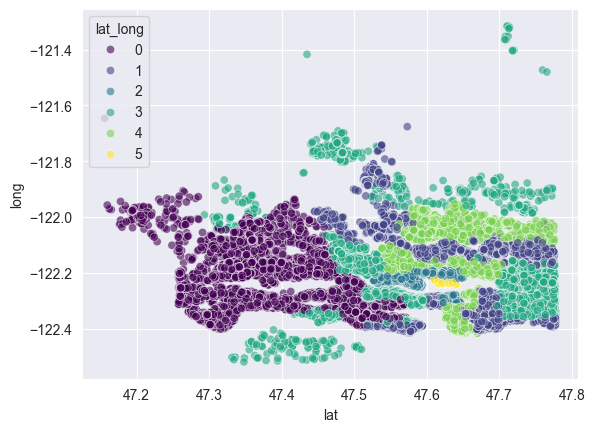

In [14]:
df = df.with_columns(pl.Series(name="lat_long", values=KMeans(n_clusters=6).fit_predict(
    df[["lat", "long", "zipcode_group"]].to_numpy())))
sns.scatterplot(data=df.to_pandas(), x="lat", y="long", hue="lat_long", palette="viridis", alpha=0.6)

In [15]:
df.head()

shape: (5, 25)
┌────────────┬──────────┬──────────┬───────────┬───┬─────┬───────────┬───────────────┬──────────┐
│ date       ┆ price    ┆ bedrooms ┆ bathrooms ┆ … ┆ age ┆ renovated ┆ zipcode_group ┆ lat_long │
│ ---        ┆ ---      ┆ ---      ┆ ---       ┆   ┆ --- ┆ ---       ┆ ---           ┆ ---      │
│ date       ┆ f64      ┆ i64      ┆ f64       ┆   ┆ i64 ┆ i32       ┆ f64           ┆ i32      │
╞════════════╪══════════╪══════════╪═══════════╪═══╪═════╪═══════════╪═══════════════╪══════════╡
│ 2014-10-13 ┆ 221900.0 ┆ 3        ┆ 1.0       ┆ … ┆ 59  ┆ 0         ┆ 278277.0      ┆ 0        │
│ 2014-12-09 ┆ 538000.0 ┆ 3        ┆ 2.25      ┆ … ┆ 63  ┆ 1         ┆ 425000.0      ┆ 3        │
│ 2015-02-25 ┆ 180000.0 ┆ 2        ┆ 1.0       ┆ … ┆ 82  ┆ 0         ┆ 445000.0      ┆ 3        │
│ 2014-12-09 ┆ 604000.0 ┆ 4        ┆ 3.0       ┆ … ┆ 49  ┆ 0         ┆ 489950.0      ┆ 1        │
│ 2015-02-18 ┆ 510000.0 ┆ 3        ┆ 2.0       ┆ … ┆ 28  ┆ 0         ┆ 642000.0      ┆ 4        │
└────────────┴──────────┴──────────┴───────────┴───┴─────┴───────────┴───────────────┴──────────┘

<Axes: >

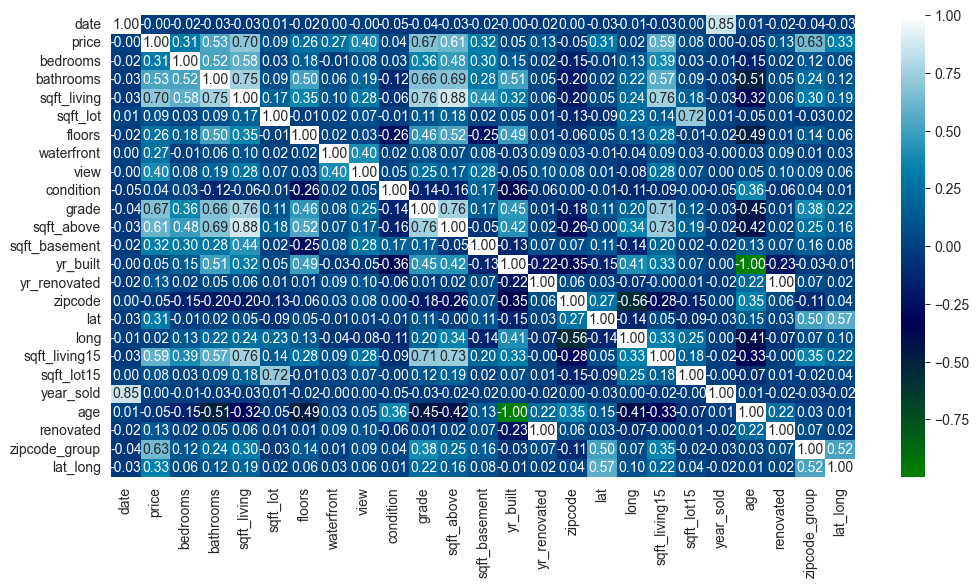

In [16]:
plt.figure(figsize=(12, 6))
correlation: DataFrame = df.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap="ocean", annot=True,
            fmt=".2f")

<Axes: >

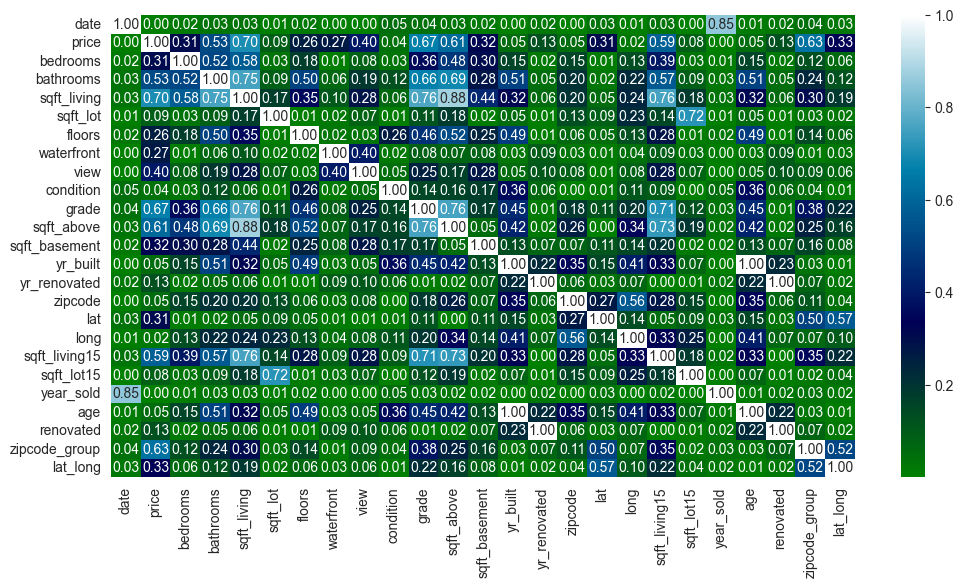

In [17]:
plt.figure(figsize=(12, 6))
sns.heatmap(abs(correlation.to_numpy()),
            xticklabels=correlation.columns,
            yticklabels=correlation.columns,
            cmap="ocean",
            annot=True,
            fmt=".2f")

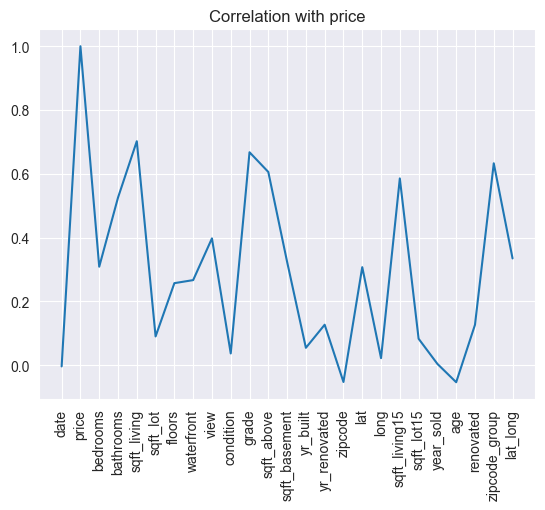

In [18]:
sns.lineplot(correlation["price"])
plt.xticks(ticks=range(len(correlation)), labels=correlation.columns, rotation=90)
plt.title("Correlation with price")
plt.show()

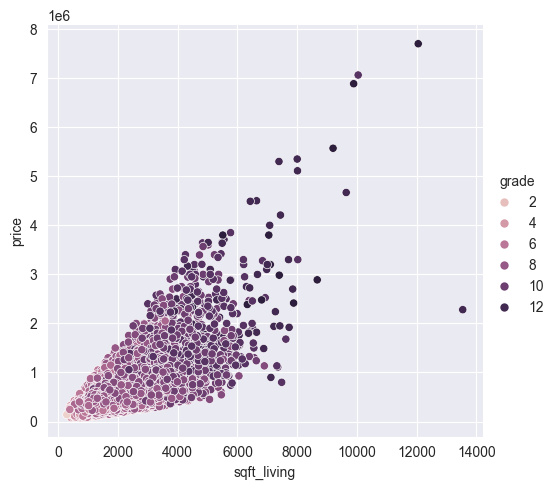

In [19]:
sns.relplot(df, x="sqft_living", y="price", hue="grade")

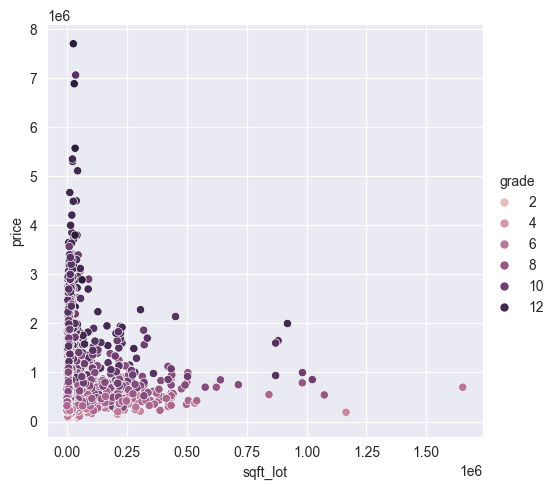

In [20]:
sns.relplot(df, x="sqft_lot", y="price", hue="grade")

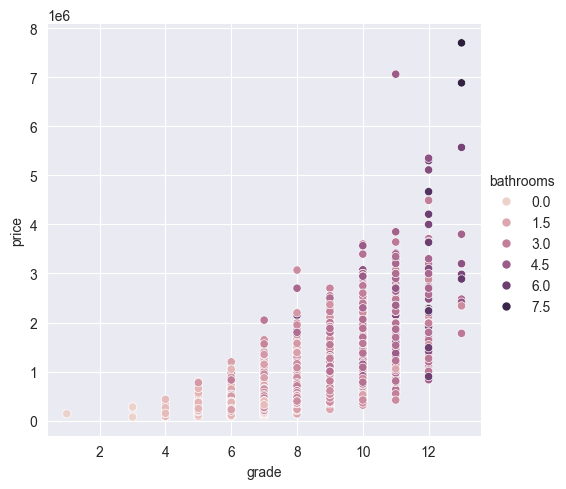

In [21]:
sns.relplot(df, x="grade", y="price", hue="bathrooms")

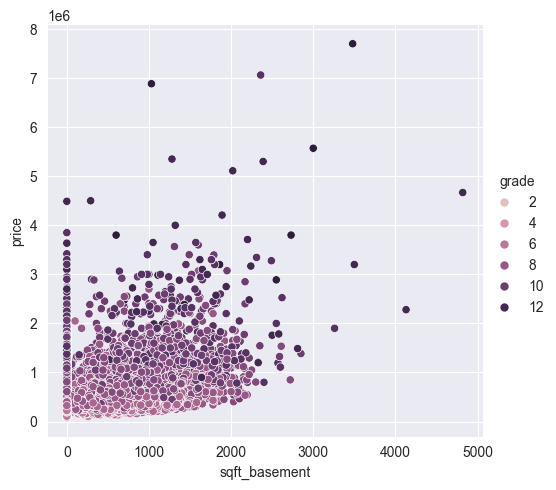

In [22]:
sns.relplot(df, x="sqft_basement", y="price", hue="grade")

In [23]:
# Find the row corresponding to 'price'
price_corr = correlation["price"]
mask = abs(price_corr) > 0.2
columns = [correlation.columns[i] for i, m in enumerate(mask) if m]
columns.remove("price")
columns.remove("lat")
columns

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'zipcode_group',
 'lat_long']

In [24]:
type(df.columns)
a: list = [1, 2, 3, 4, 5]
a.index(3)

2

In [25]:
column_types = df.dtypes
print(type(column_types))
column_types_set = set(column_types)
for col in column_types_set:
    print(col)
    col_types = [df.columns[i] for i, c in enumerate(column_types) if c == col]
    print(col_types)
    print("--")
print(len(column_types))

<class 'list'>
Int32
['year_sold', 'renovated', 'lat_long']
--
Date
['date']
--
Float64
['price', 'bathrooms', 'floors', 'lat', 'long', 'zipcode_group']
--
Int64
['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15', 'age']
--
25


In [26]:
columns_grouped_by_type = {}
for col in columns:
    col_type = column_types[df.columns.index(col)]
    if col_type not in columns_grouped_by_type:
        columns_grouped_by_type[col_type] = []
    columns_grouped_by_type[col_type].append(col)
print(columns_grouped_by_type)

{Int64: ['bedrooms', 'sqft_living', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15'], Float64: ['bathrooms', 'floors', 'zipcode_group'], Int32: ['lat_long']}


## Outlier detection

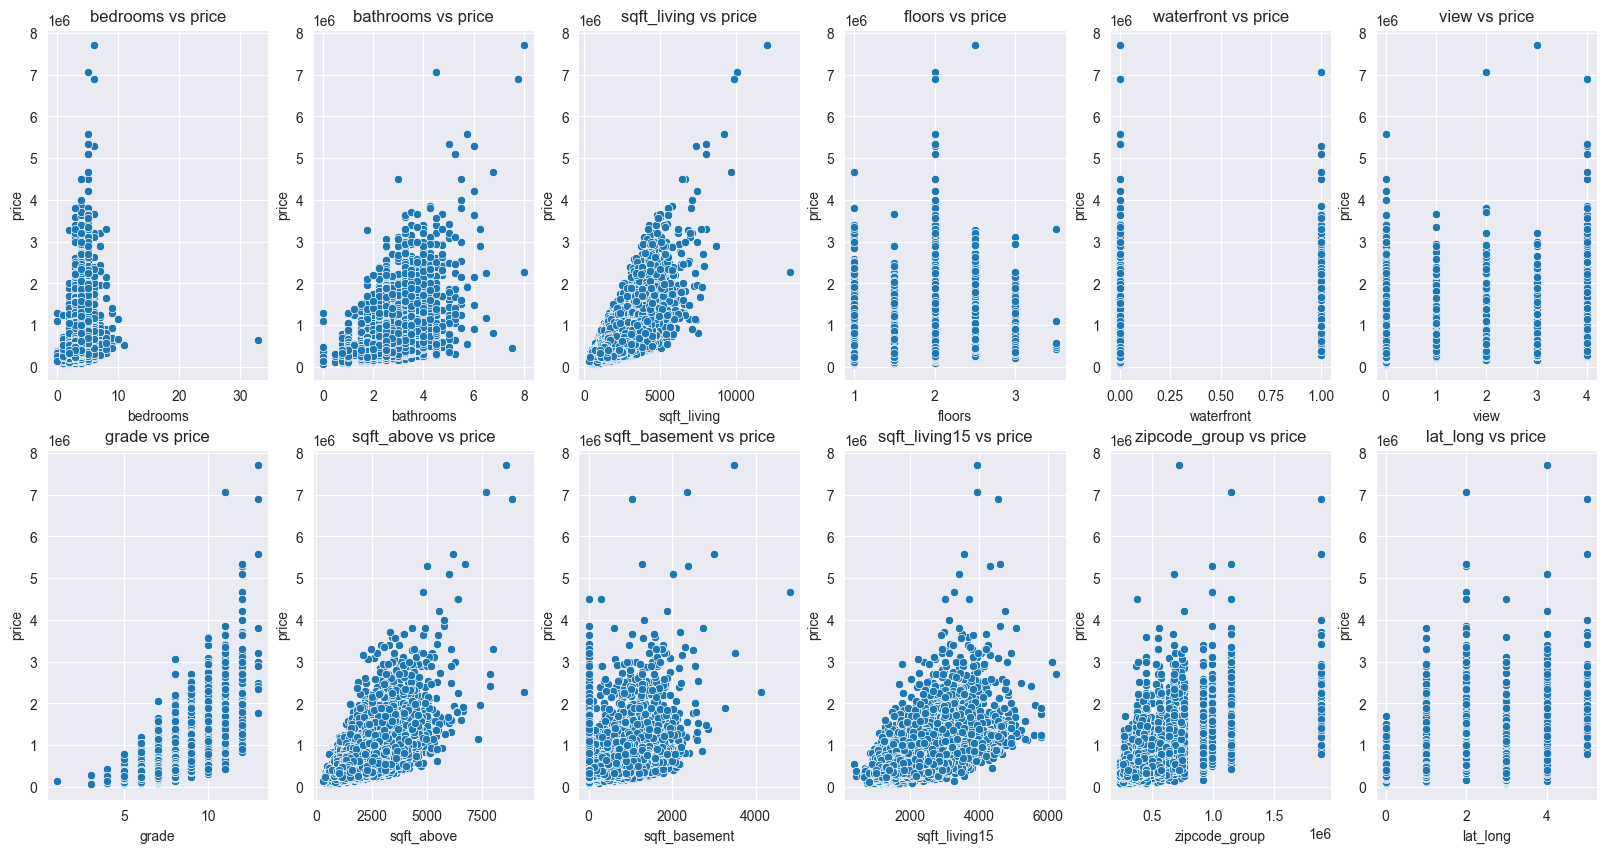

In [27]:
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
for i, column in enumerate(columns):
    row = int(i / 6)
    col = i % 6
    sns.scatterplot(df, x=column, y="price", ax=axs[row, col])
    axs[row, col].set_title(f"{column} vs price")

['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'zipcode_group', 'lat_long']
12


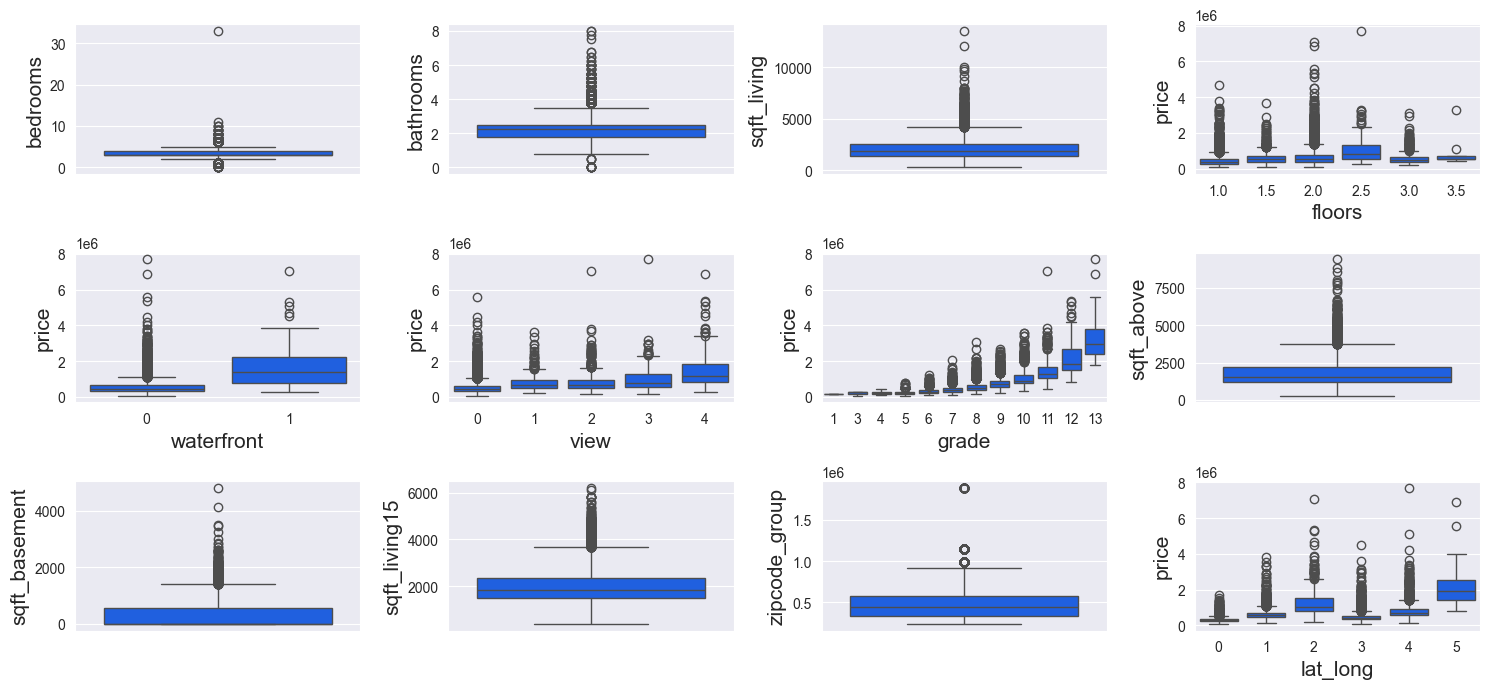

In [28]:
# Set style and custom palette
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']

sns.set_palette(sns.color_palette(colors))

# Create subplots
fig, ax = plt.subplots(3, 4, figsize=(15, 7), dpi=100)

print(columns)
print(len(columns))

# Iterate over columns
for i, col in enumerate(columns):
    x = i // 4
    y = i % 4

    if col in ["waterfront", "floors", "grade", "view", "lat_long"]:  # Categorical columns
        sns.boxplot(data=df, x=col, y='price', ax=ax[x, y])
        ax[x, y].xaxis.label.set_size(15)
        ax[x, y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=df, y=col, ax=ax[x, y])
        ax[x, y].yaxis.label.set_size(15)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

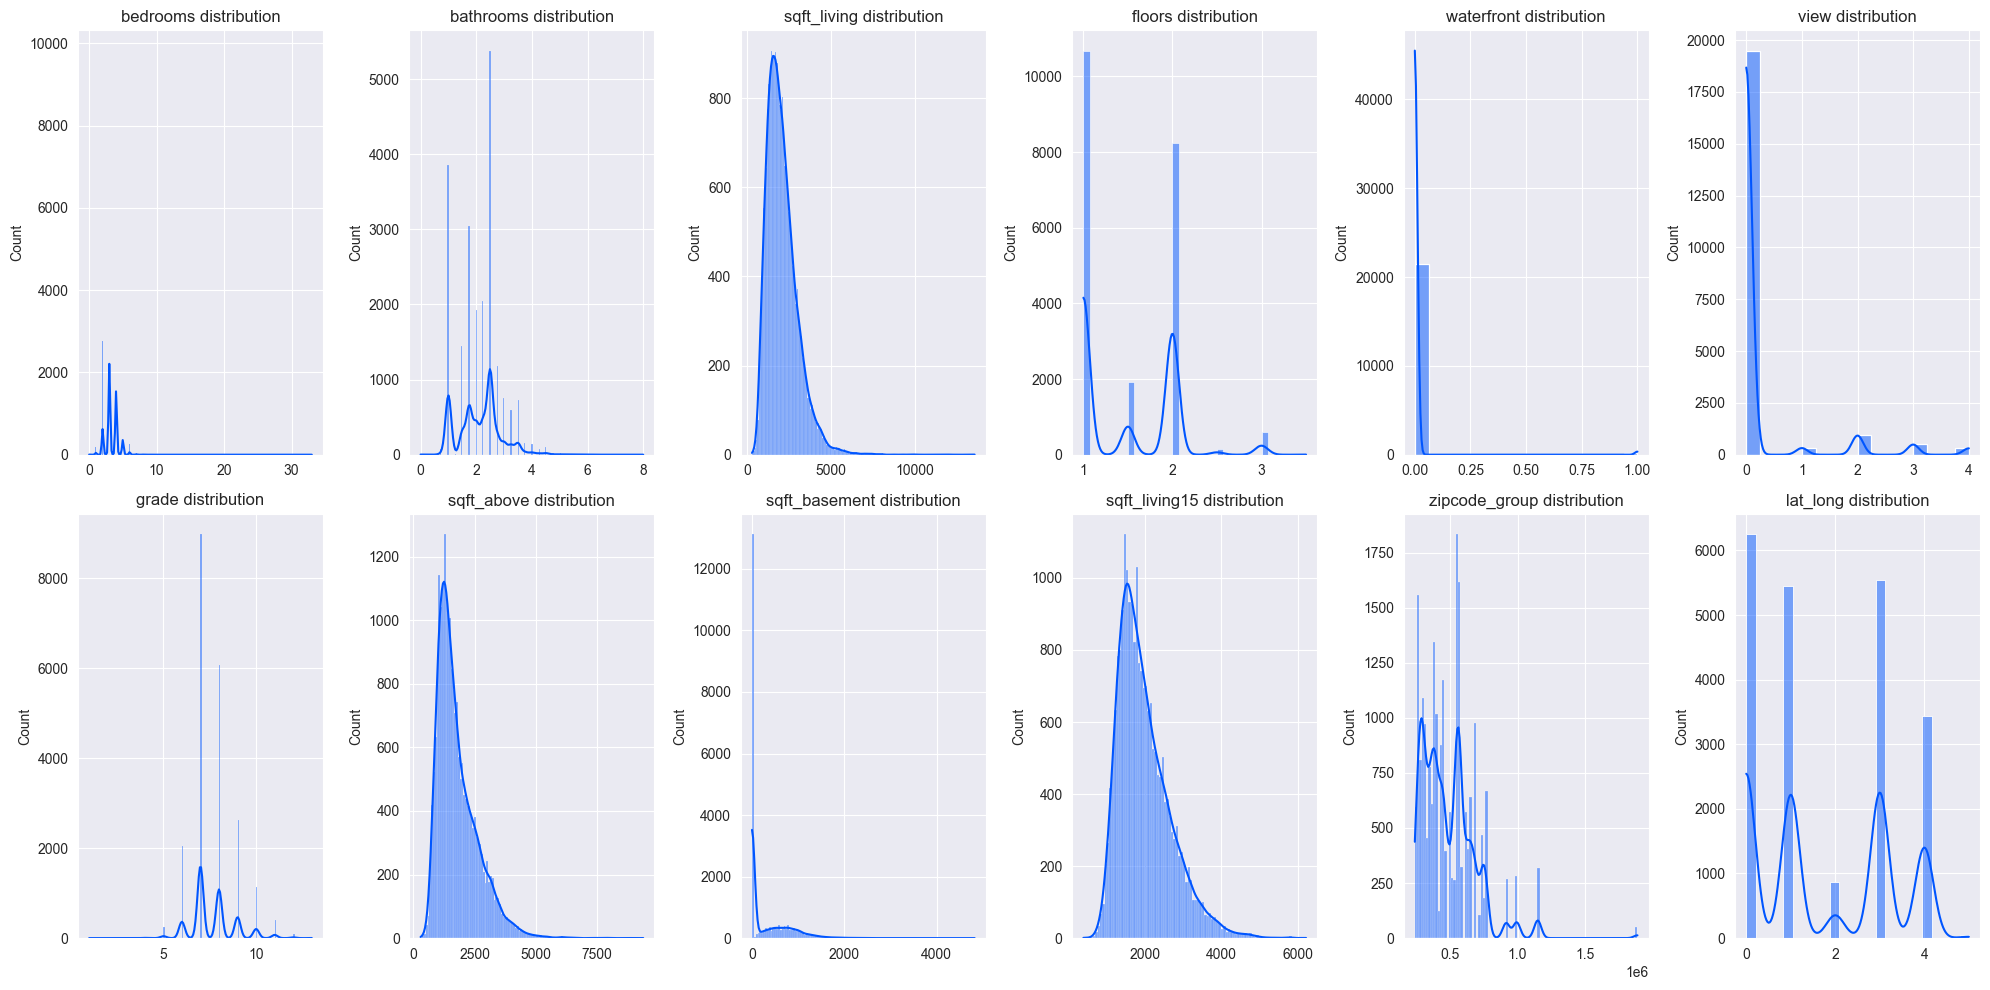

In [29]:
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
for i, column in enumerate(columns):
    row = int(i / 6)
    col = i % 6
    sns.histplot(df[column], ax=axs[row, col], kde=True)
    axs[row, col].set_title(f"{column} distribution")
plt.tight_layout()

## Prepare data

In [30]:
X = df[columns].to_numpy()
y = df["price"].to_numpy().reshape(-1, 1)

In [31]:
X.shape, y.shape

((21613, 12), (21613, 1))

## Split train and test data

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Train the model

In [33]:
reg = LinearRegression()
model = reg.fit(X_train, y_train)

In [34]:
model.coef_, model.intercept_

(array([[-2.37929316e+04, -1.74406298e+03, -3.24180714e+02,
         -2.81309517e+04,  6.08147281e+05,  7.46085630e+04,
          5.21825640e+04,  5.27611772e+02,  5.08650116e+02,
         -4.82611924e+01,  8.62941957e-01, -5.16504670e+03]]),
 array([-486471.71770029]))

## Evaluate the model

In [35]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_test, y_pred=y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MAE: {} MSE: {} RMSE: {} R^2 {}'.format(mae, mse, rmse, r2))

MAE: 109580.54191207812 MSE: 31994644814.4764 RMSE: 178870.46937512184 R^2 0.7580944877041247


## Visualize your result

Text(0, 0.5, 'y-actual')

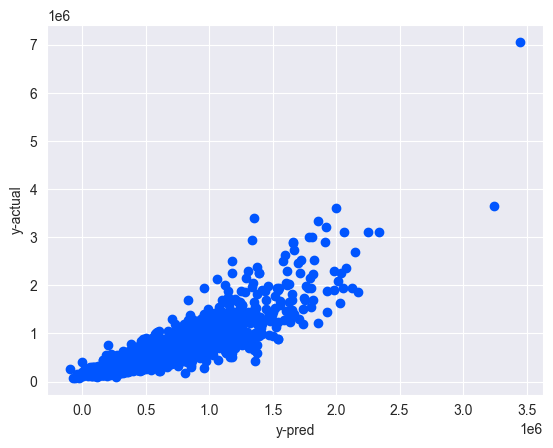

In [36]:
plt.scatter(y_pred, y_test)
plt.xlabel('y-pred')
plt.ylabel('y-actual')

## Loading data

In [37]:
load_data("shivachandel/kc-house-data", "../Data")
df = pl.read_csv("../Data/kc_house_data.csv", try_parse_dates=True)

Dataset URL: https://www.kaggle.com/datasets/shivachandel/kc-house-data


## Data exploration

In [38]:
df.head()

shape: (5, 21)
┌────────────┬────────────┬──────────┬──────────┬───┬─────────┬──────────┬────────────┬────────────┐
│ id         ┆ date       ┆ price    ┆ bedrooms ┆ … ┆ lat     ┆ long     ┆ sqft_livin ┆ sqft_lot15 │
│ ---        ┆ ---        ┆ ---      ┆ ---      ┆   ┆ ---     ┆ ---      ┆ g15        ┆ ---        │
│ i64        ┆ str        ┆ f64      ┆ i64      ┆   ┆ f64     ┆ f64      ┆ ---        ┆ i64        │
│            ┆            ┆          ┆          ┆   ┆         ┆          ┆ i64        ┆            │
╞════════════╪════════════╪══════════╪══════════╪═══╪═════════╪══════════╪════════════╪════════════╡
│ 7129300520 ┆ 20141013T0 ┆ 221900.0 ┆ 3        ┆ … ┆ 47.5112 ┆ -122.257 ┆ 1340       ┆ 5650       │
│            ┆ 00000      ┆          ┆          ┆   ┆         ┆          ┆            ┆            │
│ 6414100192 ┆ 20141209T0 ┆ 538000.0 ┆ 3        ┆ … ┆ 47.721  ┆ -122.319 ┆ 1690       ┆ 7639       │
│            ┆ 00000      ┆          ┆          ┆   ┆         ┆          ┆            ┆            │
│ 5631500400 ┆ 20150225T0 ┆ 180000.0 ┆ 2        ┆ … ┆ 47.7379 ┆ -122.233 ┆ 2720       ┆ 8062       │
│            ┆ 00000      ┆          ┆          ┆   ┆         ┆          ┆            ┆            │
│ 2487200875 ┆ 20141209T0 ┆ 604000.0 ┆ 4        ┆ … ┆ 47.5208 ┆ -122.393 ┆ 1360       ┆ 5000       │
│            ┆ 00000      ┆          ┆          ┆   ┆         ┆          ┆            ┆            │
│ 1954400510 ┆ 20150218T0 ┆ 510000.0 ┆ 3        ┆ … ┆ 47.6168 ┆ -122.045 ┆ 1800       ┆ 7503       │
│            ┆ 00000      ┆          ┆          ┆   ┆         ┆          ┆            ┆            │
└────────────┴────────────┴──────────┴──────────┴───┴─────────┴──────────┴────────────┴────────────┘

In [39]:
print(f"Original number of columns: {len(df.columns)}")

Original number of columns: 21


In [40]:
df.describe()

shape: (9, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ id        ┆ date      ┆ price     ┆ … ┆ lat       ┆ long      ┆ sqft_livi ┆ sqft_lot │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ng15      ┆ 15       │
│ str       ┆ f64       ┆ str       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 21613.0   ┆ 21613     ┆ 21613.0   ┆ … ┆ 21613.0   ┆ 21613.0   ┆ 21613.0   ┆ 21613.0  │
│ null_coun ┆ 0.0       ┆ 0         ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 4.5803e9  ┆ null      ┆ 540088.14 ┆ … ┆ 47.560053 ┆ -122.2138 ┆ 1986.5524 ┆ 12768.45 │
│           ┆           ┆           ┆ 1767      ┆   ┆           ┆ 96        ┆ 92        ┆ 5652     │
│ std       ┆ 2.8766e9  ┆ null      ┆ 367127.19 ┆ … ┆ 0.138564  ┆ 0.140828  ┆ 685.39130 ┆ 27304.17 │
│           ┆           ┆           ┆ 6483      ┆   ┆           ┆           ┆ 4         ┆ 9631     │
│ min       ┆ 1.000102e ┆ 20140502T ┆ 75000.0   ┆ … ┆ 47.1559   ┆ -122.519  ┆ 399.0     ┆ 651.0    │
│           ┆ 6         ┆ 000000    ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25%       ┆ 2.1230e9  ┆ null      ┆ 321950.0  ┆ … ┆ 47.471    ┆ -122.328  ┆ 1490.0    ┆ 5100.0   │
│ 50%       ┆ 3.9049e9  ┆ null      ┆ 450000.0  ┆ … ┆ 47.5718   ┆ -122.23   ┆ 1840.0    ┆ 7620.0   │
│ 75%       ┆ 7.3089e9  ┆ null      ┆ 645000.0  ┆ … ┆ 47.678    ┆ -122.125  ┆ 2360.0    ┆ 10083.0  │
│ max       ┆ 9.9000e9  ┆ 20150527T ┆ 7.7e6     ┆ … ┆ 47.7776   ┆ -121.315  ┆ 6210.0    ┆ 871200.0 │
│           ┆           ┆ 000000    ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [41]:
df = df.with_columns(pl.col("date").str.strptime(pl.Date, "%Y%m%dT%H%M%S"))
df = df.with_columns(pl.col("sqft_above").fill_null(strategy="mean"))

In [42]:
df.head()

shape: (5, 21)
┌────────────┬────────────┬──────────┬──────────┬───┬─────────┬──────────┬────────────┬────────────┐
│ id         ┆ date       ┆ price    ┆ bedrooms ┆ … ┆ lat     ┆ long     ┆ sqft_livin ┆ sqft_lot15 │
│ ---        ┆ ---        ┆ ---      ┆ ---      ┆   ┆ ---     ┆ ---      ┆ g15        ┆ ---        │
│ i64        ┆ date       ┆ f64      ┆ i64      ┆   ┆ f64     ┆ f64      ┆ ---        ┆ i64        │
│            ┆            ┆          ┆          ┆   ┆         ┆          ┆ i64        ┆            │
╞════════════╪════════════╪══════════╪══════════╪═══╪═════════╪══════════╪════════════╪════════════╡
│ 7129300520 ┆ 2014-10-13 ┆ 221900.0 ┆ 3        ┆ … ┆ 47.5112 ┆ -122.257 ┆ 1340       ┆ 5650       │
│ 6414100192 ┆ 2014-12-09 ┆ 538000.0 ┆ 3        ┆ … ┆ 47.721  ┆ -122.319 ┆ 1690       ┆ 7639       │
│ 5631500400 ┆ 2015-02-25 ┆ 180000.0 ┆ 2        ┆ … ┆ 47.7379 ┆ -122.233 ┆ 2720       ┆ 8062       │
│ 2487200875 ┆ 2014-12-09 ┆ 604000.0 ┆ 4        ┆ … ┆ 47.5208 ┆ -122.393 ┆ 1360       ┆ 5000       │
│ 1954400510 ┆ 2015-02-18 ┆ 510000.0 ┆ 3        ┆ … ┆ 47.6168 ┆ -122.045 ┆ 1800       ┆ 7503       │
└────────────┴────────────┴──────────┴──────────┴───┴─────────┴──────────┴────────────┴────────────┘

In [43]:
df = df.drop(["id"])
df.describe()

shape: (9, 21)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ statistic ┆ date      ┆ price     ┆ bedrooms ┆ … ┆ lat       ┆ long      ┆ sqft_livi ┆ sqft_lot1 │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ ---       ┆ ---       ┆ ng15      ┆ 5         │
│ str       ┆ str       ┆ f64       ┆ f64      ┆   ┆ f64       ┆ f64       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆          ┆   ┆           ┆           ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count     ┆ 21613     ┆ 21613.0   ┆ 21613.0  ┆ … ┆ 21613.0   ┆ 21613.0   ┆ 21613.0   ┆ 21613.0   │
│ null_coun ┆ 0         ┆ 0.0       ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ t         ┆           ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ mean      ┆ 2014-10-2 ┆ 540088.14 ┆ 3.370842 ┆ … ┆ 47.560053 ┆ -122.2138 ┆ 1986.5524 ┆ 12768.455 │
│           ┆ 9 04:38:0 ┆ 1767      ┆          ┆   ┆           ┆ 96        ┆ 92        ┆ 652       │
│           ┆ 1.959000  ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ std       ┆ null      ┆ 367127.19 ┆ 0.930062 ┆ … ┆ 0.138564  ┆ 0.140828  ┆ 685.39130 ┆ 27304.179 │
│           ┆           ┆ 6483      ┆          ┆   ┆           ┆           ┆ 4         ┆ 631       │
│ min       ┆ 2014-05-0 ┆ 75000.0   ┆ 0.0      ┆ … ┆ 47.1559   ┆ -122.519  ┆ 399.0     ┆ 651.0     │
│           ┆ 2         ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ 25%       ┆ 2014-07-2 ┆ 321950.0  ┆ 3.0      ┆ … ┆ 47.471    ┆ -122.328  ┆ 1490.0    ┆ 5100.0    │
│           ┆ 2         ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ 50%       ┆ 2014-10-1 ┆ 450000.0  ┆ 3.0      ┆ … ┆ 47.5718   ┆ -122.23   ┆ 1840.0    ┆ 7620.0    │
│           ┆ 6         ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ 75%       ┆ 2015-02-1 ┆ 645000.0  ┆ 4.0      ┆ … ┆ 47.678    ┆ -122.125  ┆ 2360.0    ┆ 10083.0   │
│           ┆ 7         ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
│ max       ┆ 2015-05-2 ┆ 7.7e6     ┆ 33.0     ┆ … ┆ 47.7776   ┆ -121.315  ┆ 6210.0    ┆ 871200.0  │
│           ┆ 7         ┆           ┆          ┆   ┆           ┆           ┆           ┆           │
└───────────┴───────────┴───────────┴──────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [44]:
df.null_count()

shape: (1, 20)
┌──────┬───────┬──────────┬───────────┬───┬─────┬──────┬───────────────┬────────────┐
│ date ┆ price ┆ bedrooms ┆ bathrooms ┆ … ┆ lat ┆ long ┆ sqft_living15 ┆ sqft_lot15 │
│ ---  ┆ ---   ┆ ---      ┆ ---       ┆   ┆ --- ┆ ---  ┆ ---           ┆ ---        │
│ u32  ┆ u32   ┆ u32      ┆ u32       ┆   ┆ u32 ┆ u32  ┆ u32           ┆ u32        │
╞══════╪═══════╪══════════╪═══════════╪═══╪═════╪══════╪═══════════════╪════════════╡
│ 0    ┆ 0     ┆ 0        ┆ 0         ┆ … ┆ 0   ┆ 0    ┆ 0             ┆ 0          │
└──────┴───────┴──────────┴───────────┴───┴─────┴──────┴───────────────┴────────────┘

In [45]:
sum(df.is_duplicated())

0

In [46]:
df = df.with_columns(
    pl.col("date").dt.year().alias("year_sold")
)

In [47]:
df = df.with_columns(
    pl.when(pl.col("year_sold") - pl.col("yr_built") > 0)
    .then(pl.col("year_sold") - pl.col("yr_built"))
    .otherwise(0)
    .alias("age")
)

In [48]:
df = df.with_columns(
    pl.when(pl.col("yr_renovated") > 0)
    .then(1)
    .otherwise(0)
    .alias("renovated")
)

In [49]:
zipcode_median = df.group_by("zipcode").agg(pl.col("price").median().alias("zipcode_group"))
zipcode_median

shape: (70, 2)
┌─────────┬───────────────┐
│ zipcode ┆ zipcode_group │
│ ---     ┆ ---           │
│ i64     ┆ f64           │
╞═════════╪═══════════════╡
│ 98075   ┆ 739999.0      │
│ 98072   ┆ 515000.0      │
│ 98188   ┆ 264000.0      │
│ 98126   ┆ 395750.0      │
│ 98108   ┆ 342500.0      │
│ …       ┆ …             │
│ 98006   ┆ 760184.5      │
│ 98003   ┆ 267475.0      │
│ 98024   ┆ 460000.0      │
│ 98146   ┆ 305000.0      │
│ 98030   ┆ 282255.0      │
└─────────┴───────────────┘

In [50]:
print(zipcode_median.n_unique(), df["zipcode"].n_unique())

70 70


In [51]:
df = df.join(zipcode_median, on="zipcode", how="left")

In [52]:
df = df.with_columns(pl.Series(name="zipcode_group", values=KMeans(n_clusters=3).fit_predict(
    df[["zipcode_group", "zipcode"]].to_numpy())))
print(df["zipcode_group"].n_unique(), df["zipcode"].n_unique())

3 70


<Axes: xlabel='lat', ylabel='long'>

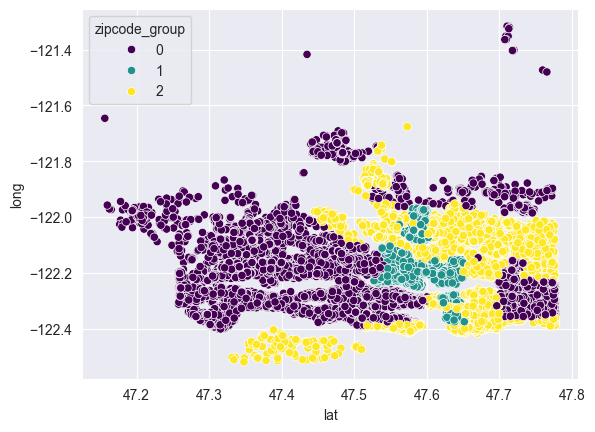

In [53]:
sns.scatterplot(data=df.to_pandas(), x="lat", y="long", hue="zipcode_group", palette="viridis", alpha=1)

<Axes: xlabel='lat', ylabel='long'>

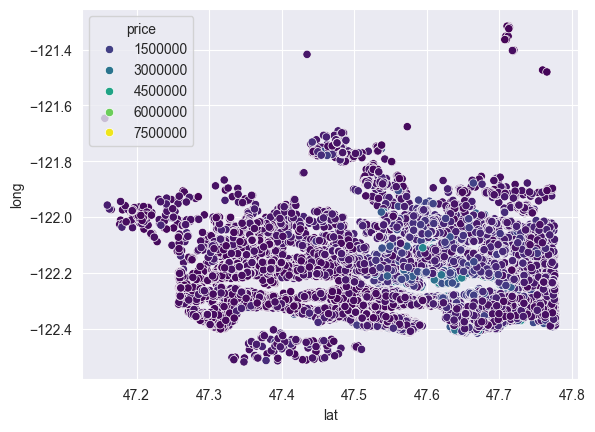

In [54]:
sns.scatterplot(data=df.to_pandas(), x="lat", y="long", hue="price", palette="viridis", alpha=1)

<Axes: xlabel='lat', ylabel='long'>

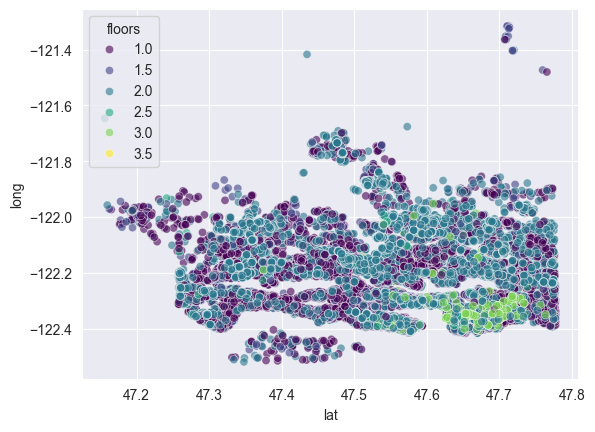

In [55]:
sns.scatterplot(data=df.to_pandas(), x="lat", y="long", hue="floors", palette="viridis", alpha=0.6)

<Axes: xlabel='lat', ylabel='long'>

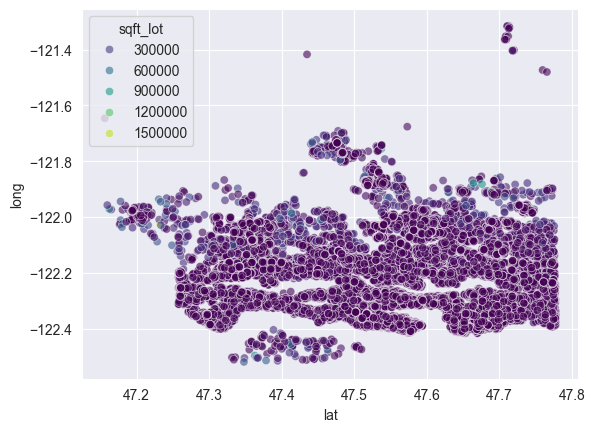

In [56]:
sns.scatterplot(data=df.to_pandas(), x="lat", y="long", hue="sqft_lot", palette="viridis", alpha=0.6)

<Axes: xlabel='lat', ylabel='long'>

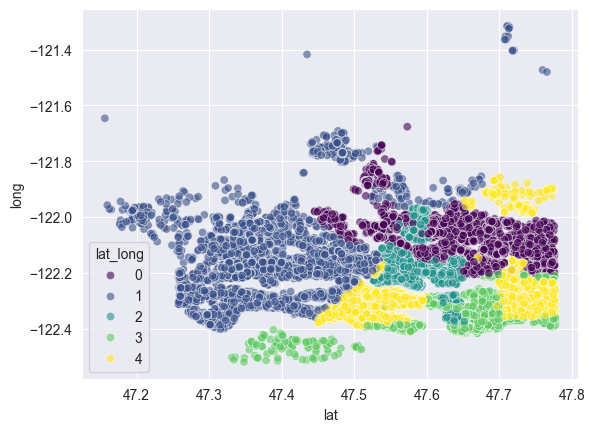

In [57]:
df = df.with_columns(pl.Series(name="lat_long", values=KMeans(n_clusters=5).fit_predict(
    df[["lat", "long", "zipcode_group"]].to_numpy())))
sns.scatterplot(data=df.to_pandas(), x="lat", y="long", hue="lat_long", palette="viridis", alpha=0.6)

In [58]:
df.head()

shape: (5, 25)
┌────────────┬──────────┬──────────┬───────────┬───┬─────┬───────────┬───────────────┬──────────┐
│ date       ┆ price    ┆ bedrooms ┆ bathrooms ┆ … ┆ age ┆ renovated ┆ zipcode_group ┆ lat_long │
│ ---        ┆ ---      ┆ ---      ┆ ---       ┆   ┆ --- ┆ ---       ┆ ---           ┆ ---      │
│ date       ┆ f64      ┆ i64      ┆ f64       ┆   ┆ i64 ┆ i32       ┆ i32           ┆ i32      │
╞════════════╪══════════╪══════════╪═══════════╪═══╪═════╪═══════════╪═══════════════╪══════════╡
│ 2014-10-13 ┆ 221900.0 ┆ 3        ┆ 1.0       ┆ … ┆ 59  ┆ 0         ┆ 0             ┆ 4        │
│ 2014-12-09 ┆ 538000.0 ┆ 3        ┆ 2.25      ┆ … ┆ 63  ┆ 1         ┆ 0             ┆ 4        │
│ 2015-02-25 ┆ 180000.0 ┆ 2        ┆ 1.0       ┆ … ┆ 82  ┆ 0         ┆ 0             ┆ 4        │
│ 2014-12-09 ┆ 604000.0 ┆ 4        ┆ 3.0       ┆ … ┆ 49  ┆ 0         ┆ 2             ┆ 3        │
│ 2015-02-18 ┆ 510000.0 ┆ 3        ┆ 2.0       ┆ … ┆ 28  ┆ 0         ┆ 2             ┆ 0        │
└────────────┴──────────┴──────────┴───────────┴───┴─────┴───────────┴───────────────┴──────────┘

<Axes: >

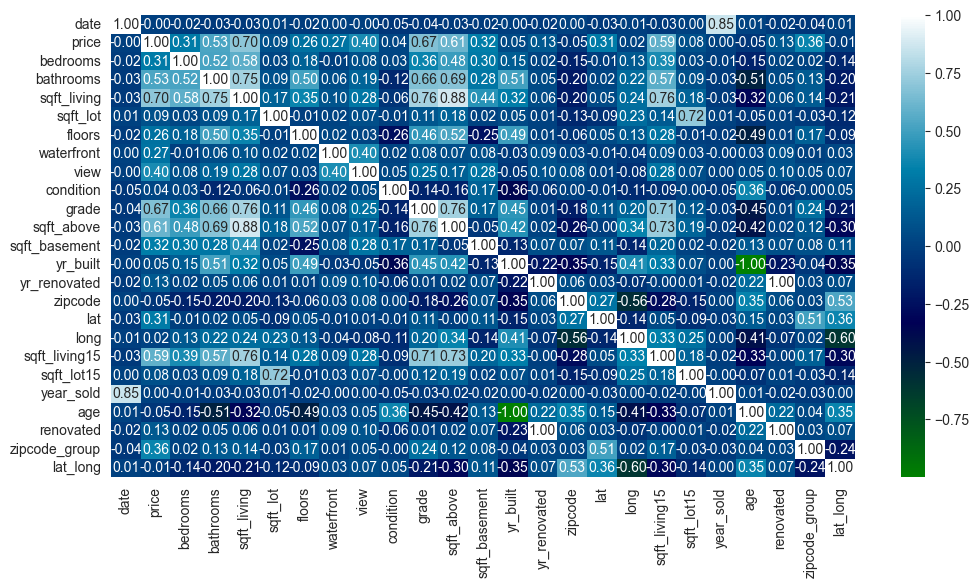

In [59]:
plt.figure(figsize=(12, 6))
correlation: DataFrame = df.corr()
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap="ocean", annot=True,
            fmt=".2f")

<Axes: >

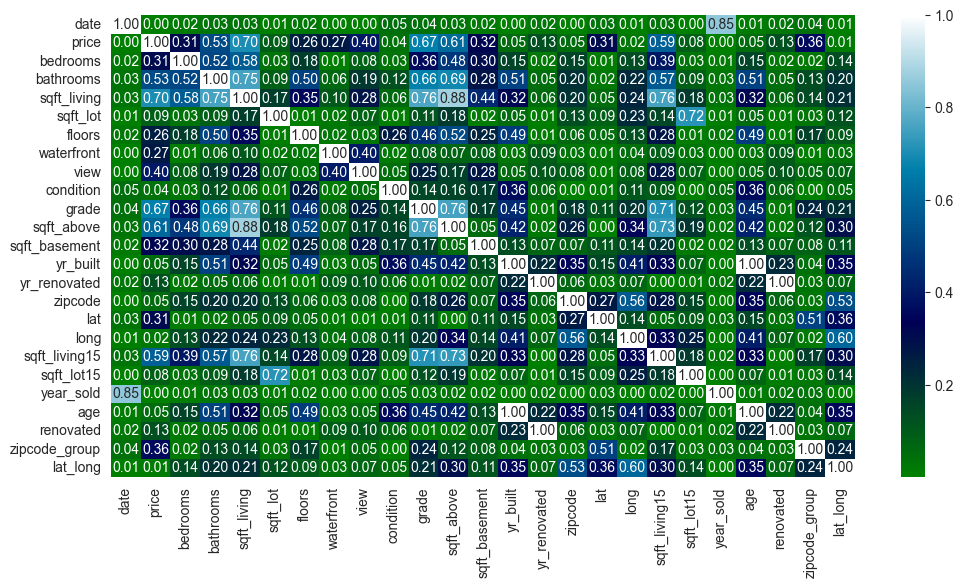

In [60]:
plt.figure(figsize=(12, 6))
sns.heatmap(abs(correlation.to_numpy()),
            xticklabels=correlation.columns,
            yticklabels=correlation.columns,
            cmap="ocean",
            annot=True,
            fmt=".2f")

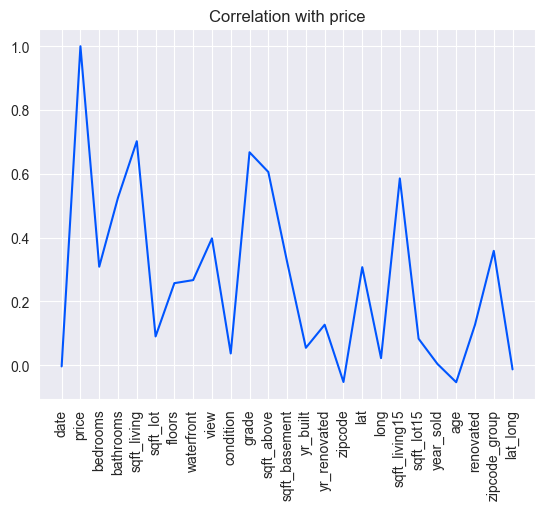

In [61]:
sns.lineplot(correlation["price"])
plt.xticks(ticks=range(len(correlation)), labels=correlation.columns, rotation=90)
plt.title("Correlation with price")
plt.show()

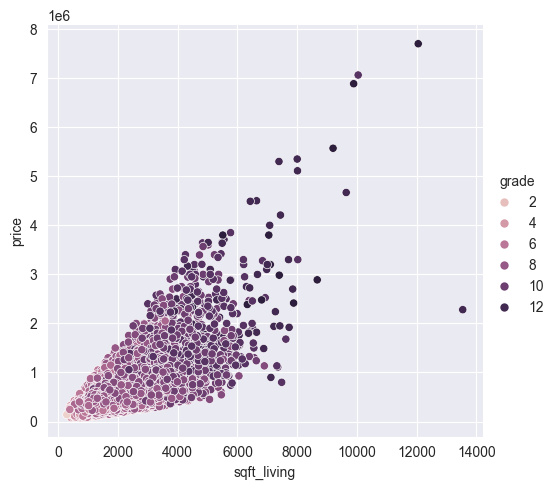

In [62]:
sns.relplot(df, x="sqft_living", y="price", hue="grade")

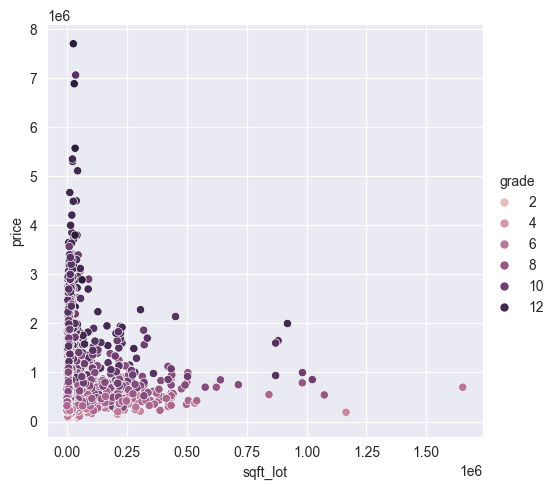

In [63]:
sns.relplot(df, x="sqft_lot", y="price", hue="grade")

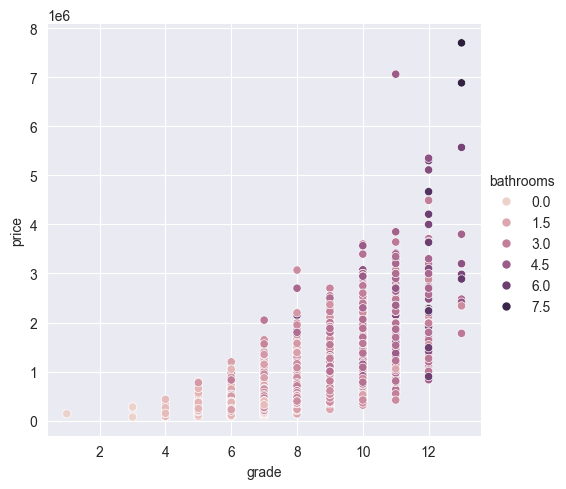

In [64]:
sns.relplot(df, x="grade", y="price", hue="bathrooms")

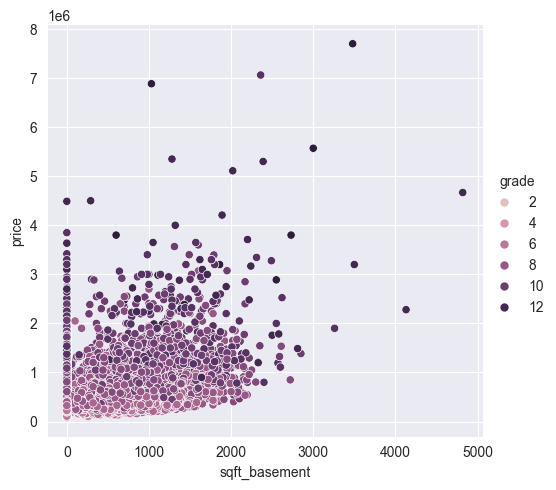

In [65]:
sns.relplot(df, x="sqft_basement", y="price", hue="grade")

In [66]:
# Find the row corresponding to 'price'
price_corr = correlation["price"]
mask = abs(price_corr) > 0.2
columns = [correlation.columns[i] for i, m in enumerate(mask) if m]
columns.remove("price")
columns.remove("lat")
columns

['bedrooms',
 'bathrooms',
 'sqft_living',
 'floors',
 'waterfront',
 'view',
 'grade',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'zipcode_group']

In [67]:
column_types = df.dtypes
print(type(column_types))
column_types_set = set(column_types)
for col in column_types_set:
    print(col)
    col_types = [df.columns[i] for i, c in enumerate(column_types) if c == col]
    print(col_types)
    print("--")
print(len(column_types))

<class 'list'>
Int32
['year_sold', 'renovated', 'zipcode_group', 'lat_long']
--
Date
['date']
--
Float64
['price', 'bathrooms', 'floors', 'lat', 'long']
--
Int64
['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'sqft_living15', 'sqft_lot15', 'age']
--
25


In [68]:
columns_grouped_by_type = {}
for col in columns:
    col_type = column_types[df.columns.index(col)]
    if col_type not in columns_grouped_by_type:
        columns_grouped_by_type[col_type] = []
    columns_grouped_by_type[col_type].append(col)
print(columns_grouped_by_type)

{Int64: ['bedrooms', 'sqft_living', 'waterfront', 'view', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15'], Float64: ['bathrooms', 'floors'], Int32: ['zipcode_group']}


## Outlier detection

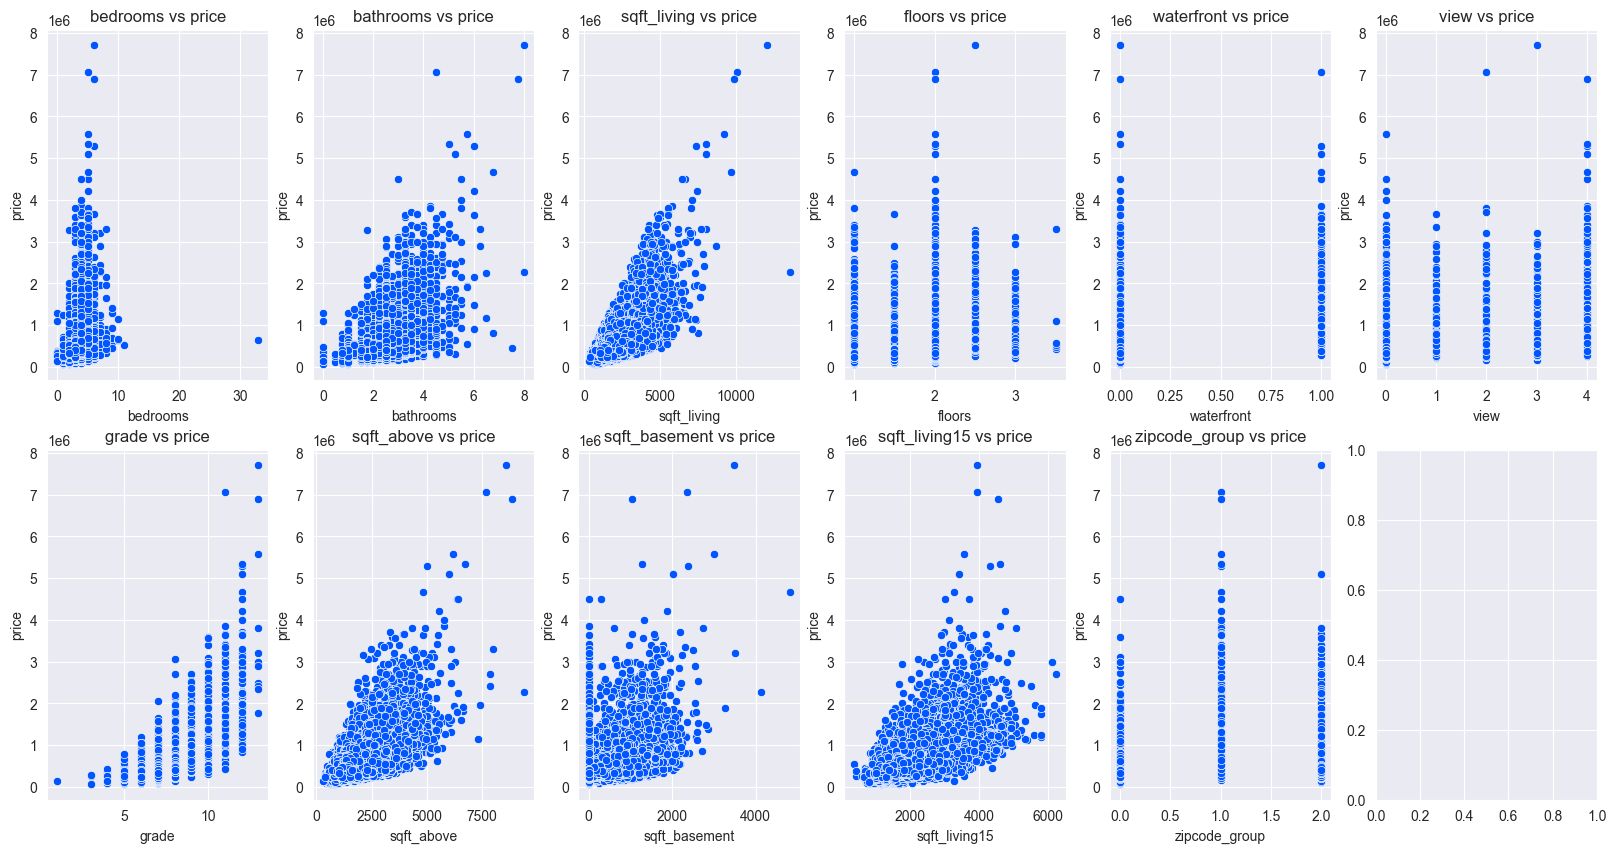

In [69]:
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
for i, column in enumerate(columns):
    row = int(i / 6)
    col = i % 6
    sns.scatterplot(df, x=column, y="price", ax=axs[row, col])
    axs[row, col].set_title(f"{column} vs price")

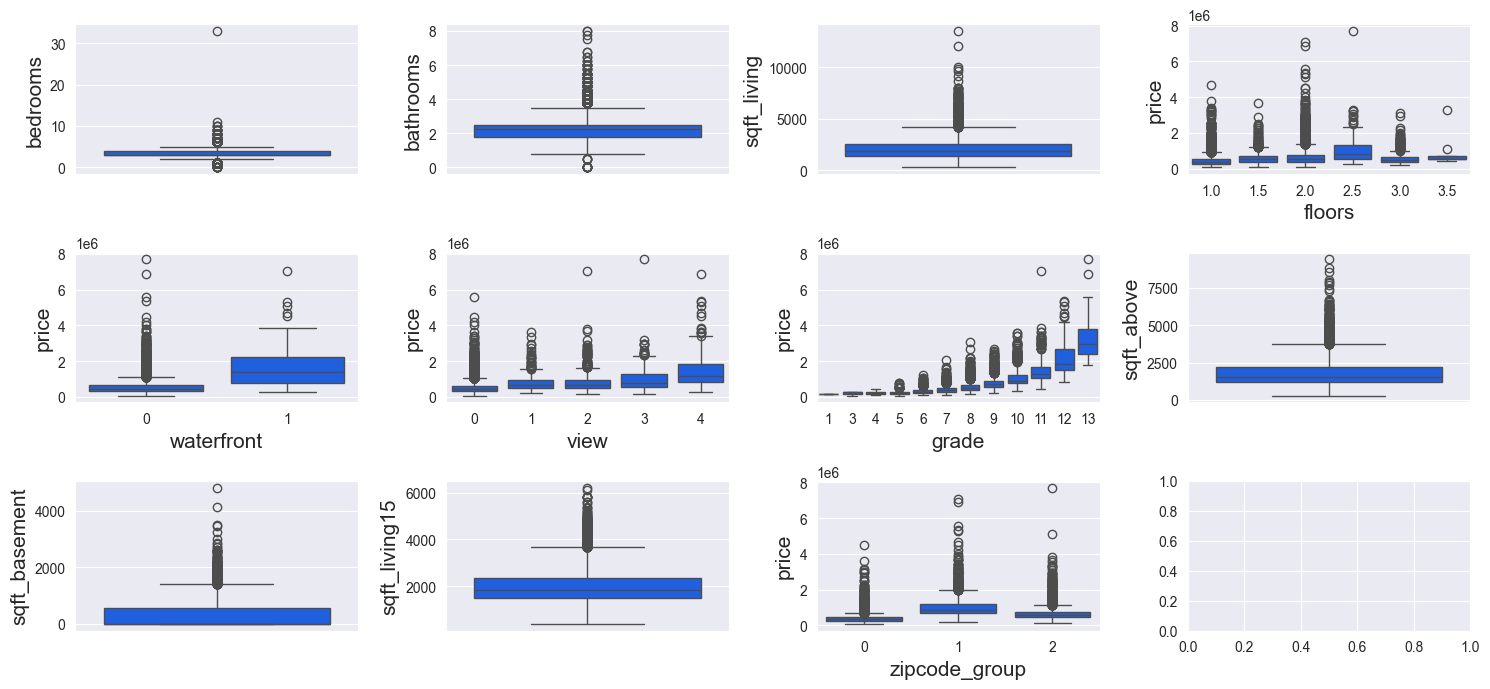

In [70]:
# Set style and custom palette
sns.set_style('darkgrid')
colors = ['#0055ff', '#ff7000', '#23bf00']

sns.set_palette(sns.color_palette(colors))

# Create subplots
fig, ax = plt.subplots(3, 4, figsize=(15, 7), dpi=100)

# Iterate over columns
for i, col in enumerate(columns):
    x = i // 4
    y = i % 4

    if col in ["waterfront", "floors", "grade", "view", "zipcode_group", "lat_long"]:  # Categorical columns
        sns.boxplot(data=df, x=col, y='price', ax=ax[x, y])
        ax[x, y].xaxis.label.set_size(15)
        ax[x, y].yaxis.label.set_size(15)
    else:
        sns.boxplot(data=df, y=col, ax=ax[x, y])
        ax[x, y].yaxis.label.set_size(15)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

11


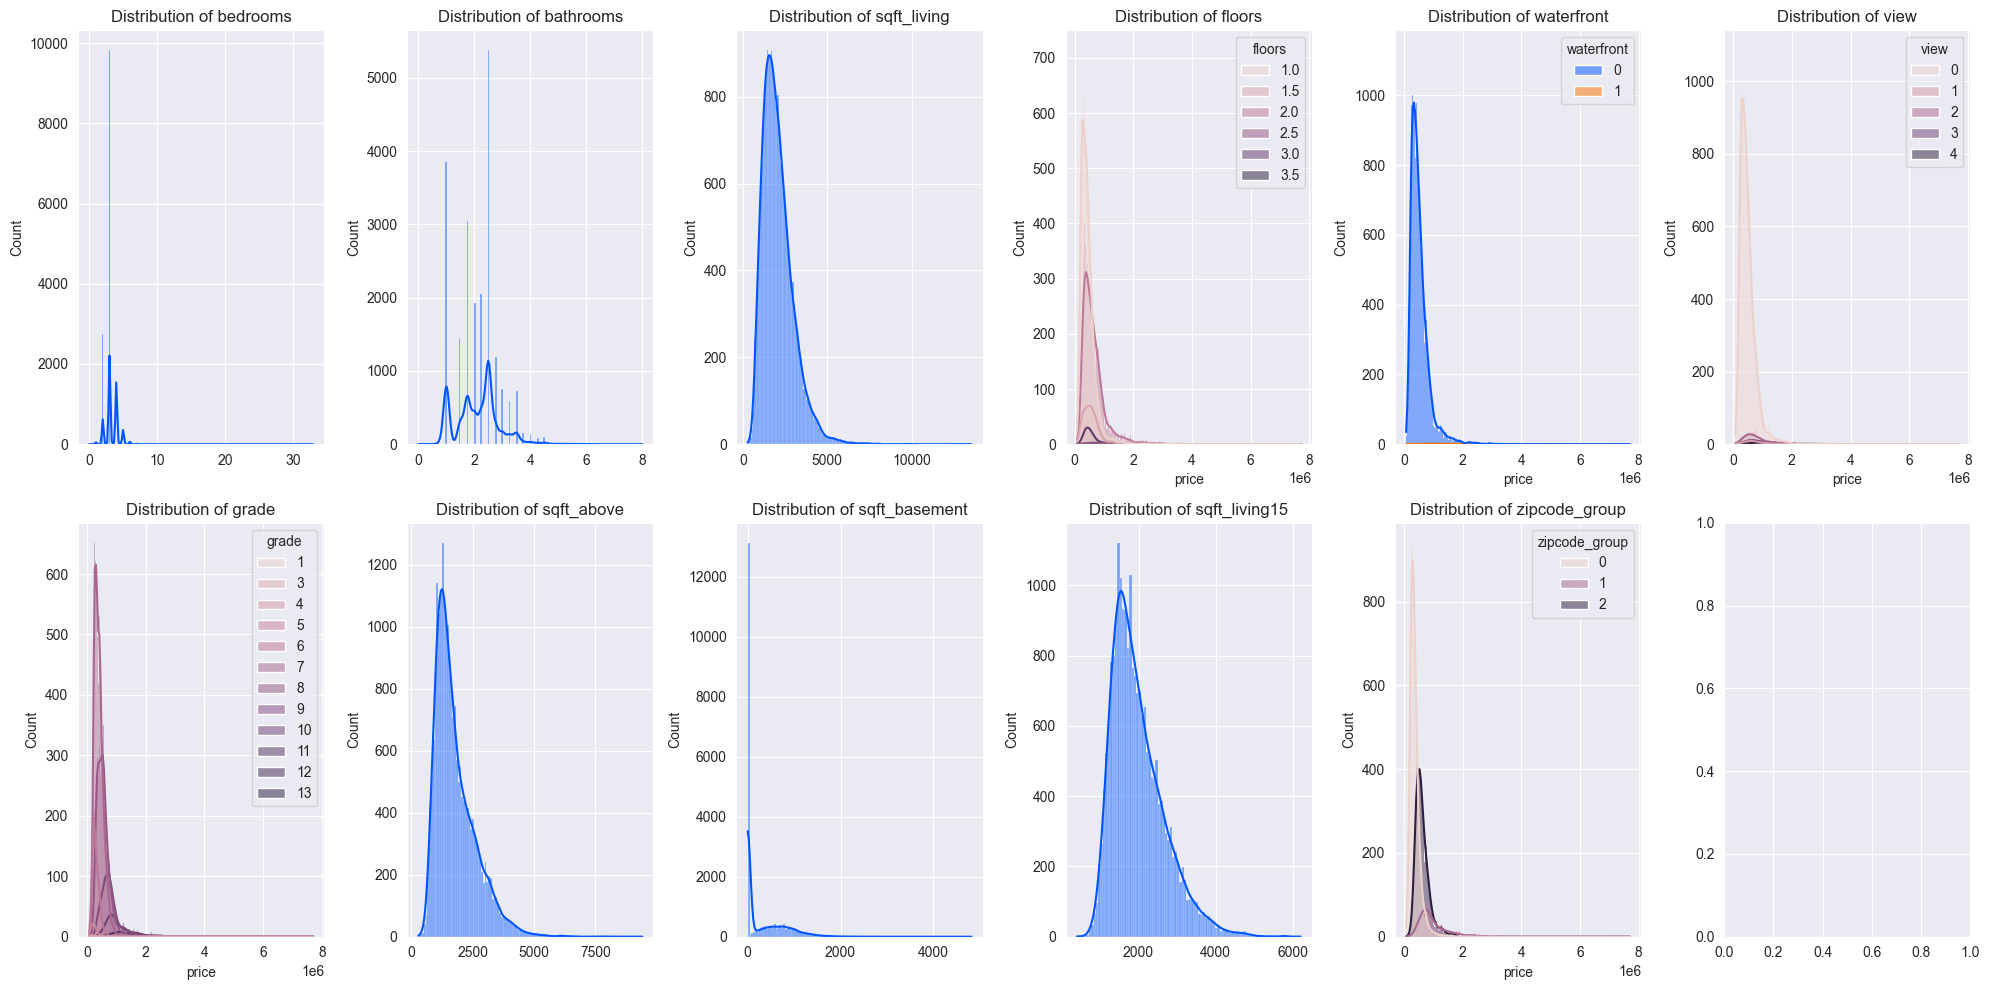

In [71]:
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
print(len(columns))
for i, column in enumerate(columns):
    row = int(i / 6)
    col = i % 6
    if column in ["waterfront", "floors", "grade", "view", "zipcode_group", "lat_long"]:  # Categorical columns
        sns.histplot(df, ax=axs[row, col], hue=column, x='price', kde=True)
    else:
        sns.histplot(df[column], ax=axs[row, col], kde=True)
    axs[row, col].set_title(f"Distribution of {column}")
plt.tight_layout()

bedrooms: 546 :2.53%
bathrooms: 571 :2.64%
sqft_living: 572 :2.65%
floors: 1019 :4.71%
waterfront: 1068 :4.94%
view: 880 :4.07%
grade: 678 :3.14%
sqft_above: 611 :2.83%
sqft_basement: 496 :2.29%
sqft_living15: 544 :2.52%
zipcode_group: 1120 :5.18%
price: 1146 :5.30%
Outliers ratio: 5.30%


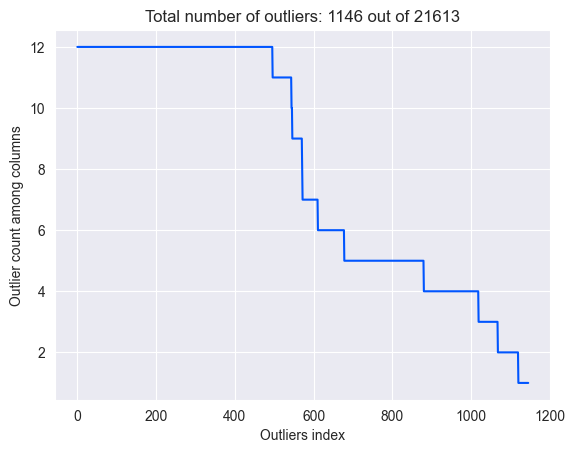

In [72]:
from collections import Counter

outlier_indices = []
target = "price"
categorical_columns = ["waterfront", "floors", "grade", "view", "zipcode_group", "lat_long"]
for col in columns + ["price"]:
    if col in categorical_columns:

        # Groups the DataFrame by the values in column col. 
        # This creates a grouped context so we can perform per-group aggregations
        grouped = df.group_by(col)

        # For each group:
        #     calculate percentiles
        outliers_df = grouped.agg(
            pl.col(target).quantile(0.25).alias("q1"),
            pl.col(target).quantile(0.75).alias("q3"),
        ).with_columns(  # calculate iqr
            (pl.col("q3") - pl.col("q1")).alias("iqr"),
        ).with_columns(
            # calculates maximum and minimum
            (pl.col("q3") + (1.5 * pl.col("iqr"))).alias("maximum"),
            (pl.col("q1") - (1.5 * pl.col("iqr"))).alias("minimum"),
        )  # This gives a new DataFrame (outliers_df) with columns: col (the group key), q1, q3

        # Join back to the original DataFrame to identify outliers
        df_with_bounds = df.join(outliers_df, on=col, how="left")

        # Filter for outliers based on the calculated bounds
        outlier_mask = (df_with_bounds[target] < df_with_bounds["minimum"]) | (
                df_with_bounds[target] > df_with_bounds["maximum"])
        outlier_indices_ = df_with_bounds.filter(outlier_mask).with_row_index().to_series().to_list()
        outlier_indices.extend(outlier_indices_)

    else:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        maximum_ = q3 + 1.5 * iqr
        minimum_ = q1 - 1.5 * iqr
        outlier_mask = (df[col] < minimum_) | (df[col] > maximum_)
        outlier_indices_ = df.filter(outlier_mask).with_row_index().to_series().to_list()
        outlier_indices.extend(outlier_indices_)

    print(f"{col}: {len(outlier_indices_)} :{len(outlier_indices_) / len(df) * 100:.2f}%")

outlier_indices = Counter(outlier_indices)
total = len(outlier_indices)
print("========")
print(f"Outliers ratio: {len(outlier_indices) / len(df) * 100:.2f}%")
plt.plot(outlier_indices.keys(), outlier_indices.values())
plt.xlabel("Outliers index")
plt.ylabel("Outlier count among columns")
plt.title(f"Total number of outliers: {total} out of {len(df)}")
plt.show()

In [73]:
remove_outlier_indices = [key for key, val in outlier_indices.items() if val < 10]
print(f"Total number of removing outliers: {len(remove_outlier_indices)} vs outliers: {total}")
print(
    f"remove outlier ratio {len(remove_outlier_indices) / len(df) * 100:.2f}% vs raw outliers ratio: {total / len(df) * 100:.2f}%")
outlier_indices = list(outlier_indices.keys() - set(remove_outlier_indices))
print(
    f"outliers ratio: {len(outlier_indices) / len(df) * 100:.2f}% vs raw outliers ratio: {total / len(df) * 100:.2f}%")

Total number of removing outliers: 600 vs outliers: 1146
remove outlier ratio 2.78% vs raw outliers ratio: 5.30%
outliers ratio: 2.53% vs raw outliers ratio: 5.30%


In [74]:
indices = pl.Series(range(len(df)))
outlier_mask = indices.is_in(outlier_indices)
print(f"Original len {len(df)}")
print(f"{len(outlier_mask)}:{sum(outlier_mask)}")
remove_outlier_mask = indices.is_in(remove_outlier_indices)
print(f"{len(remove_outlier_mask)}:{sum(remove_outlier_mask)}")
df = df.with_columns(
    pl
    .when(outlier_mask).then(pl.lit("outlier"))
    .when(remove_outlier_mask).then(pl.lit("to_remove"))
    .otherwise(pl.lit("no"))
    .alias("outlier"))

Original len 21613
21613:546
21613:600


<Axes: xlabel='price', ylabel='Count'>

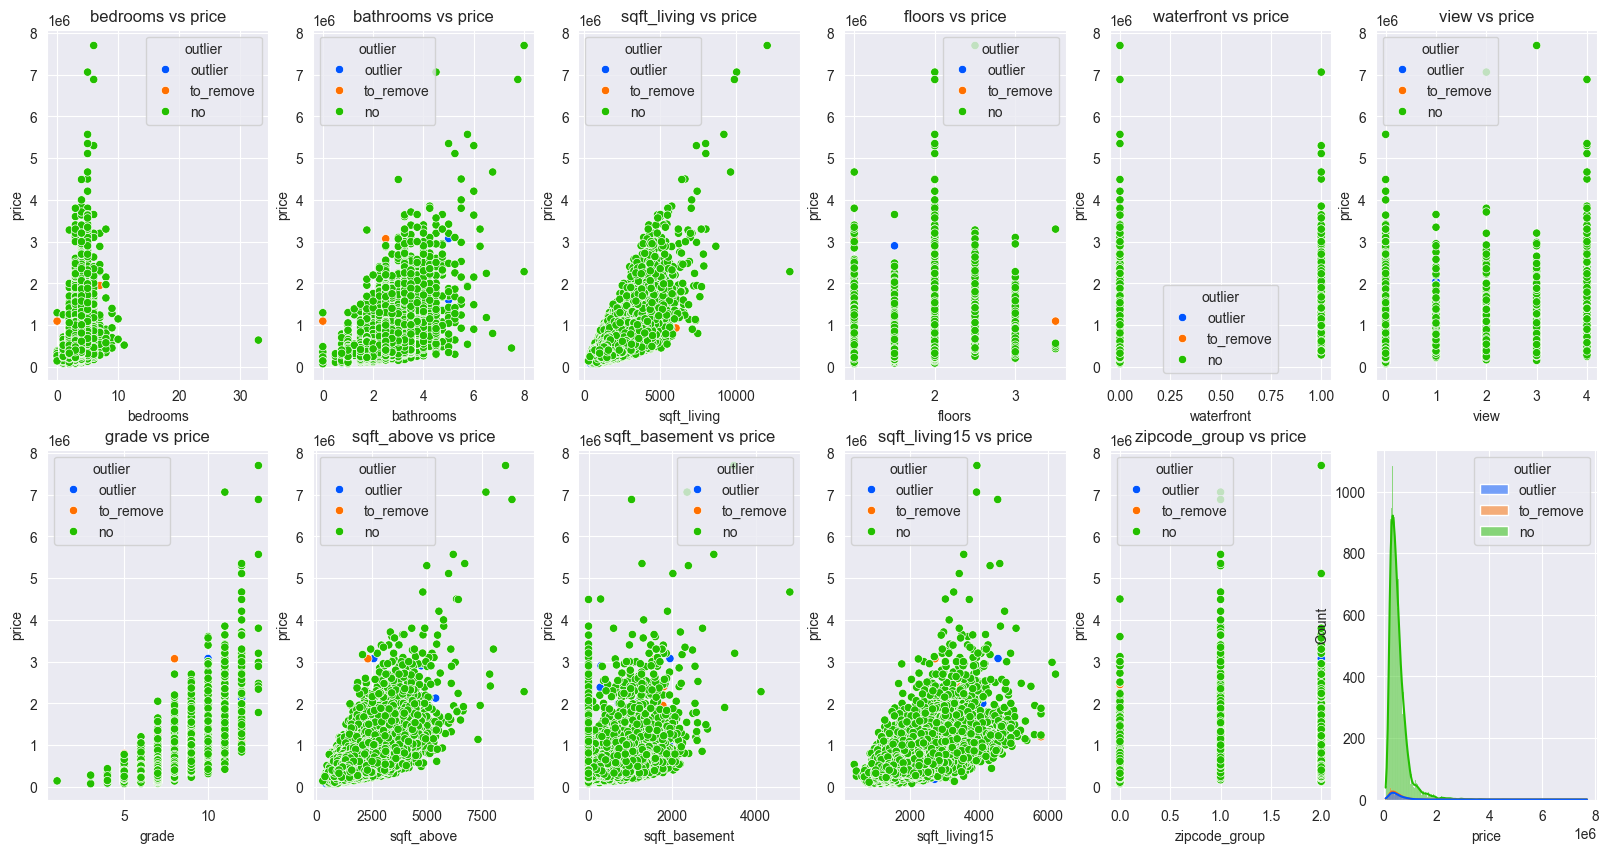

In [75]:
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
for i, column in enumerate(columns):
    row = int(i / 6)
    col = i % 6
    sns.scatterplot(df, x=column, y="price", ax=axs[row, col], hue="outlier")
    axs[row, col].set_title(f"{column} vs price")

sns.histplot(df, ax=axs[1, 5], kde=True, x="price", hue="outlier")

In [76]:
df = df.filter(df["outlier"] != "to_remove")[columns + ["price"]]

In [77]:
df.filter(~df.is_duplicated())

shape: (20_957, 12)
┌──────────┬───────────┬────────────┬────────┬───┬────────────┬────────────┬────────────┬──────────┐
│ bedrooms ┆ bathrooms ┆ sqft_livin ┆ floors ┆ … ┆ sqft_basem ┆ sqft_livin ┆ zipcode_gr ┆ price    │
│ ---      ┆ ---       ┆ g          ┆ ---    ┆   ┆ ent        ┆ g15        ┆ oup        ┆ ---      │
│ i64      ┆ f64       ┆ ---        ┆ f64    ┆   ┆ ---        ┆ ---        ┆ ---        ┆ f64      │
│          ┆           ┆ i64        ┆        ┆   ┆ i64        ┆ i64        ┆ i32        ┆          │
╞══════════╪═══════════╪════════════╪════════╪═══╪════════════╪════════════╪════════════╪══════════╡
│ 3        ┆ 1.0       ┆ 1180       ┆ 1.0    ┆ … ┆ 0          ┆ 1340       ┆ 0          ┆ 221900.0 │
│ 3        ┆ 2.25      ┆ 2570       ┆ 2.0    ┆ … ┆ 400        ┆ 1690       ┆ 0          ┆ 538000.0 │
│ 2        ┆ 1.0       ┆ 770        ┆ 1.0    ┆ … ┆ 0          ┆ 2720       ┆ 0          ┆ 180000.0 │
│ 4        ┆ 3.0       ┆ 1960       ┆ 1.0    ┆ … ┆ 910        ┆ 1360       ┆ 2          ┆ 604000.0 │
│ 3        ┆ 2.0       ┆ 1680       ┆ 1.0    ┆ … ┆ 0          ┆ 1800       ┆ 2          ┆ 510000.0 │
│ …        ┆ …         ┆ …          ┆ …      ┆ … ┆ …          ┆ …          ┆ …          ┆ …        │
│ 3        ┆ 2.5       ┆ 1530       ┆ 3.0    ┆ … ┆ 0          ┆ 1530       ┆ 2          ┆ 360000.0 │
│ 4        ┆ 2.5       ┆ 2310       ┆ 2.0    ┆ … ┆ 0          ┆ 1830       ┆ 0          ┆ 400000.0 │
│ 2        ┆ 0.75      ┆ 1020       ┆ 2.0    ┆ … ┆ 0          ┆ 1020       ┆ 0          ┆ 402101.0 │
│ 3        ┆ 2.5       ┆ 1600       ┆ 2.0    ┆ … ┆ 0          ┆ 1410       ┆ 2          ┆ 400000.0 │
│ 2        ┆ 0.75      ┆ 1020       ┆ 2.0    ┆ … ┆ 0          ┆ 1020       ┆ 0          ┆ 325000.0 │
└──────────┴───────────┴────────────┴────────┴───┴────────────┴────────────┴────────────┴──────────┘

## Exploration Data Analisis

In [78]:
categorical_columns = set(df.columns).intersection(set(categorical_columns) - {"grade", "floors"})
numerical_columns = set(df.columns) - categorical_columns - {"price"}

In [79]:
print(f"Categorical columns: {len(categorical_columns)}\nNumerical columns: {len(numerical_columns)}")

Categorical columns: 3
Numerical columns: 8


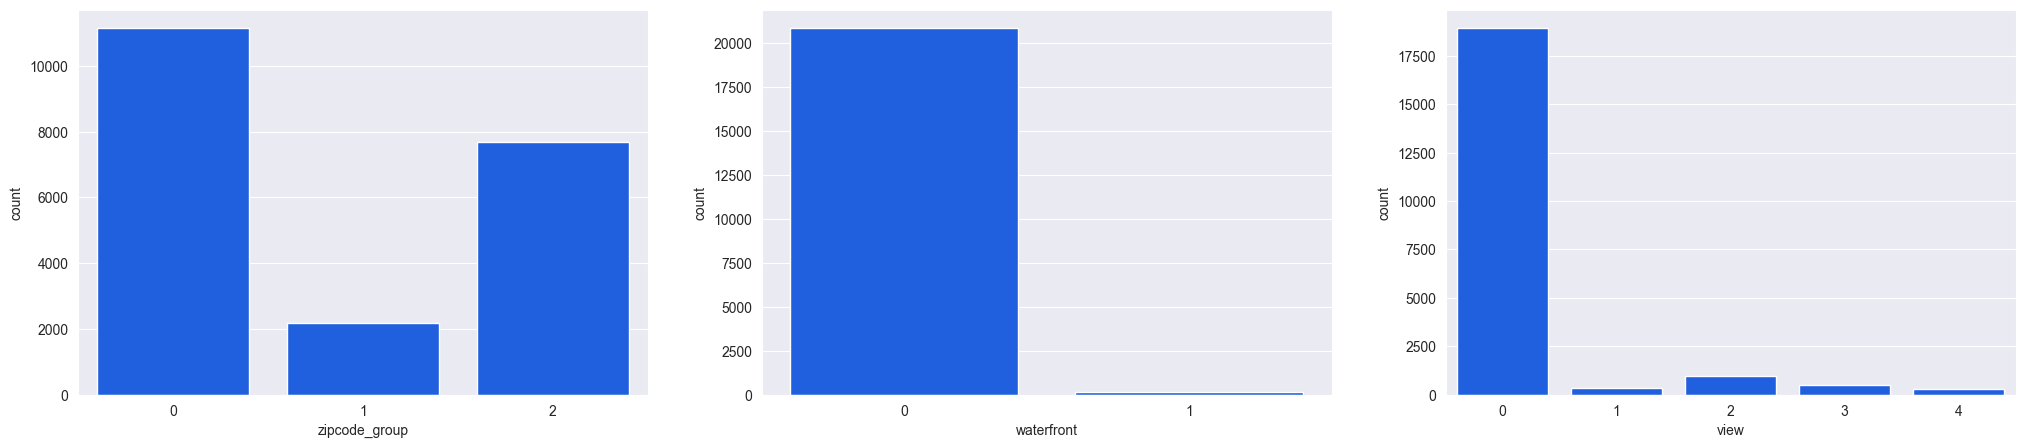

In [80]:
fig, axs = plt.subplots(1, len(categorical_columns), figsize=(25, 5))
for i, column in enumerate(categorical_columns):
    sns.countplot(df, x=column, ax=axs[i])

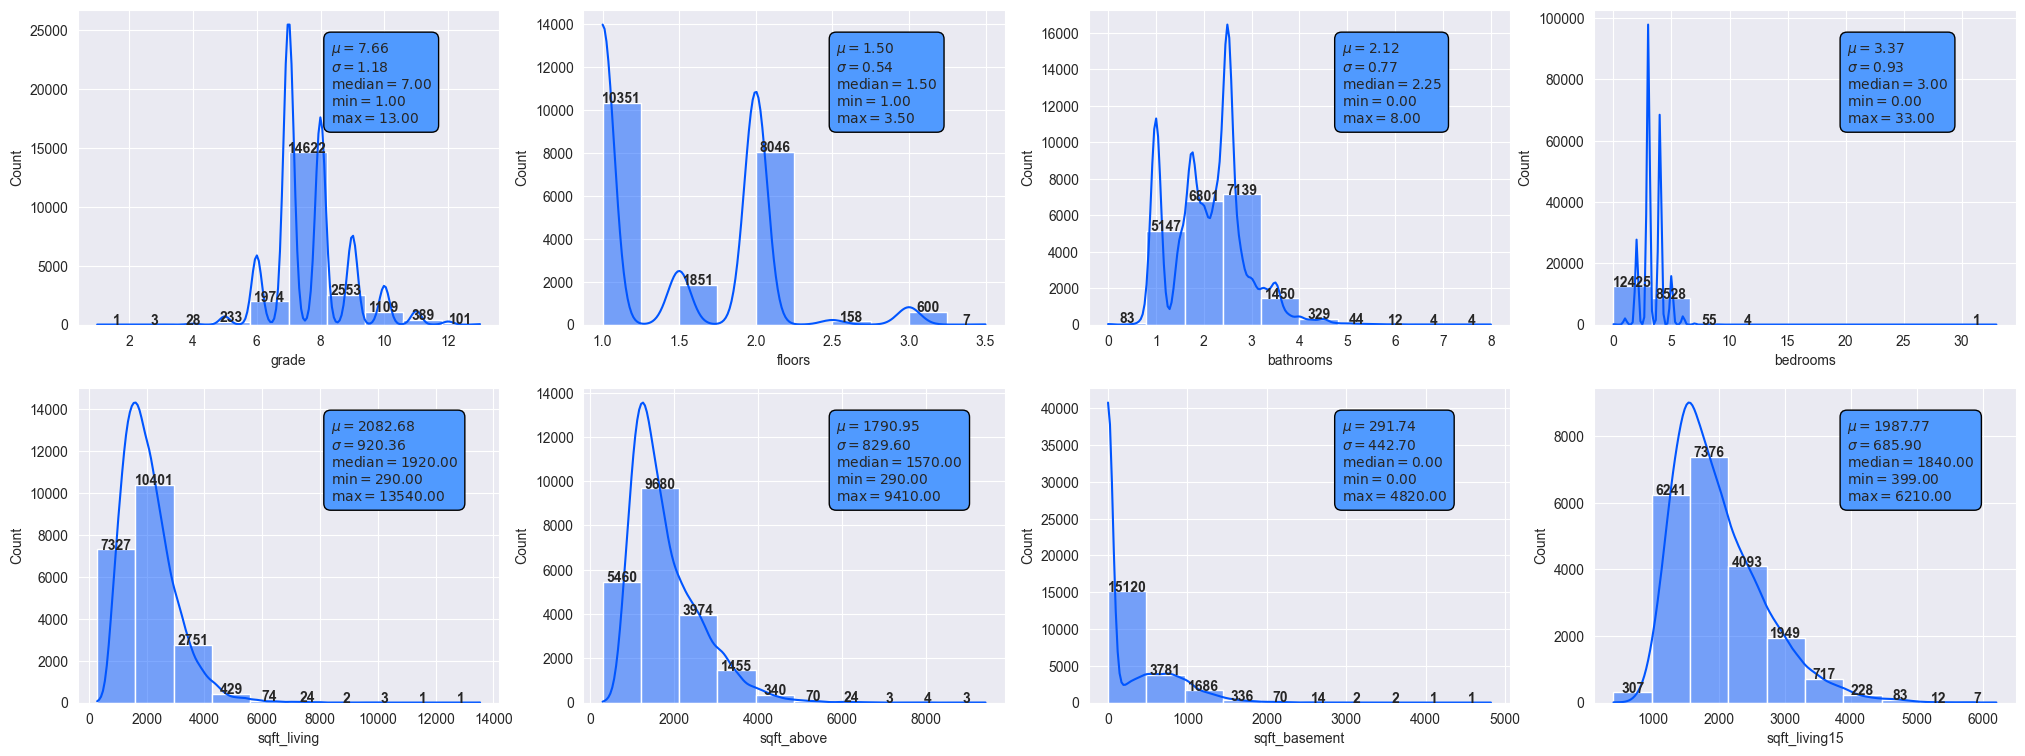

In [81]:
fig, axs = plt.subplots(2, len(numerical_columns) // 2, figsize=(25, 9))
for i, column in enumerate(numerical_columns):
    row = int(i / 4)
    col = i % 4
    values, bin_edges = np.histogram(df[column])
    graph = sns.histplot(df, x=column, ax=axs[row, col], bins=bin_edges, kde=True)
    for j, patch in enumerate(graph.patches):  #patch is the rectangle
        height = patch.get_height()
        if height > 0:
            x = patch.get_x() + patch.get_width() / 2.
            # axs[row, col].text(x, y, f'{int(height)}', ha='center', va='bottom')
            axs[row, col].annotate(f'{int(height)}', (x, height + 1), ha='center', fontsize=10, fontweight="bold")
    text_str = '\n'.join((
        r'$\mu=%.2f$' % df[column].mean(),
        r'$\sigma=%.2f$' % df[column].std(),
        r'$\mathrm{median}=%.2f$' % df[column].median(),
        r'$\mathrm{min}=%.2f$' % df[column].min(),
        r'$\mathrm{max}=%.2f$' % df[column].max()
    ))
    axs[row, col].text(0.6, 0.9, text_str, transform=axs[row, col].transAxes, fontsize=10, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='#509aff', edgecolor='black', pad=0.5))
plt.show()

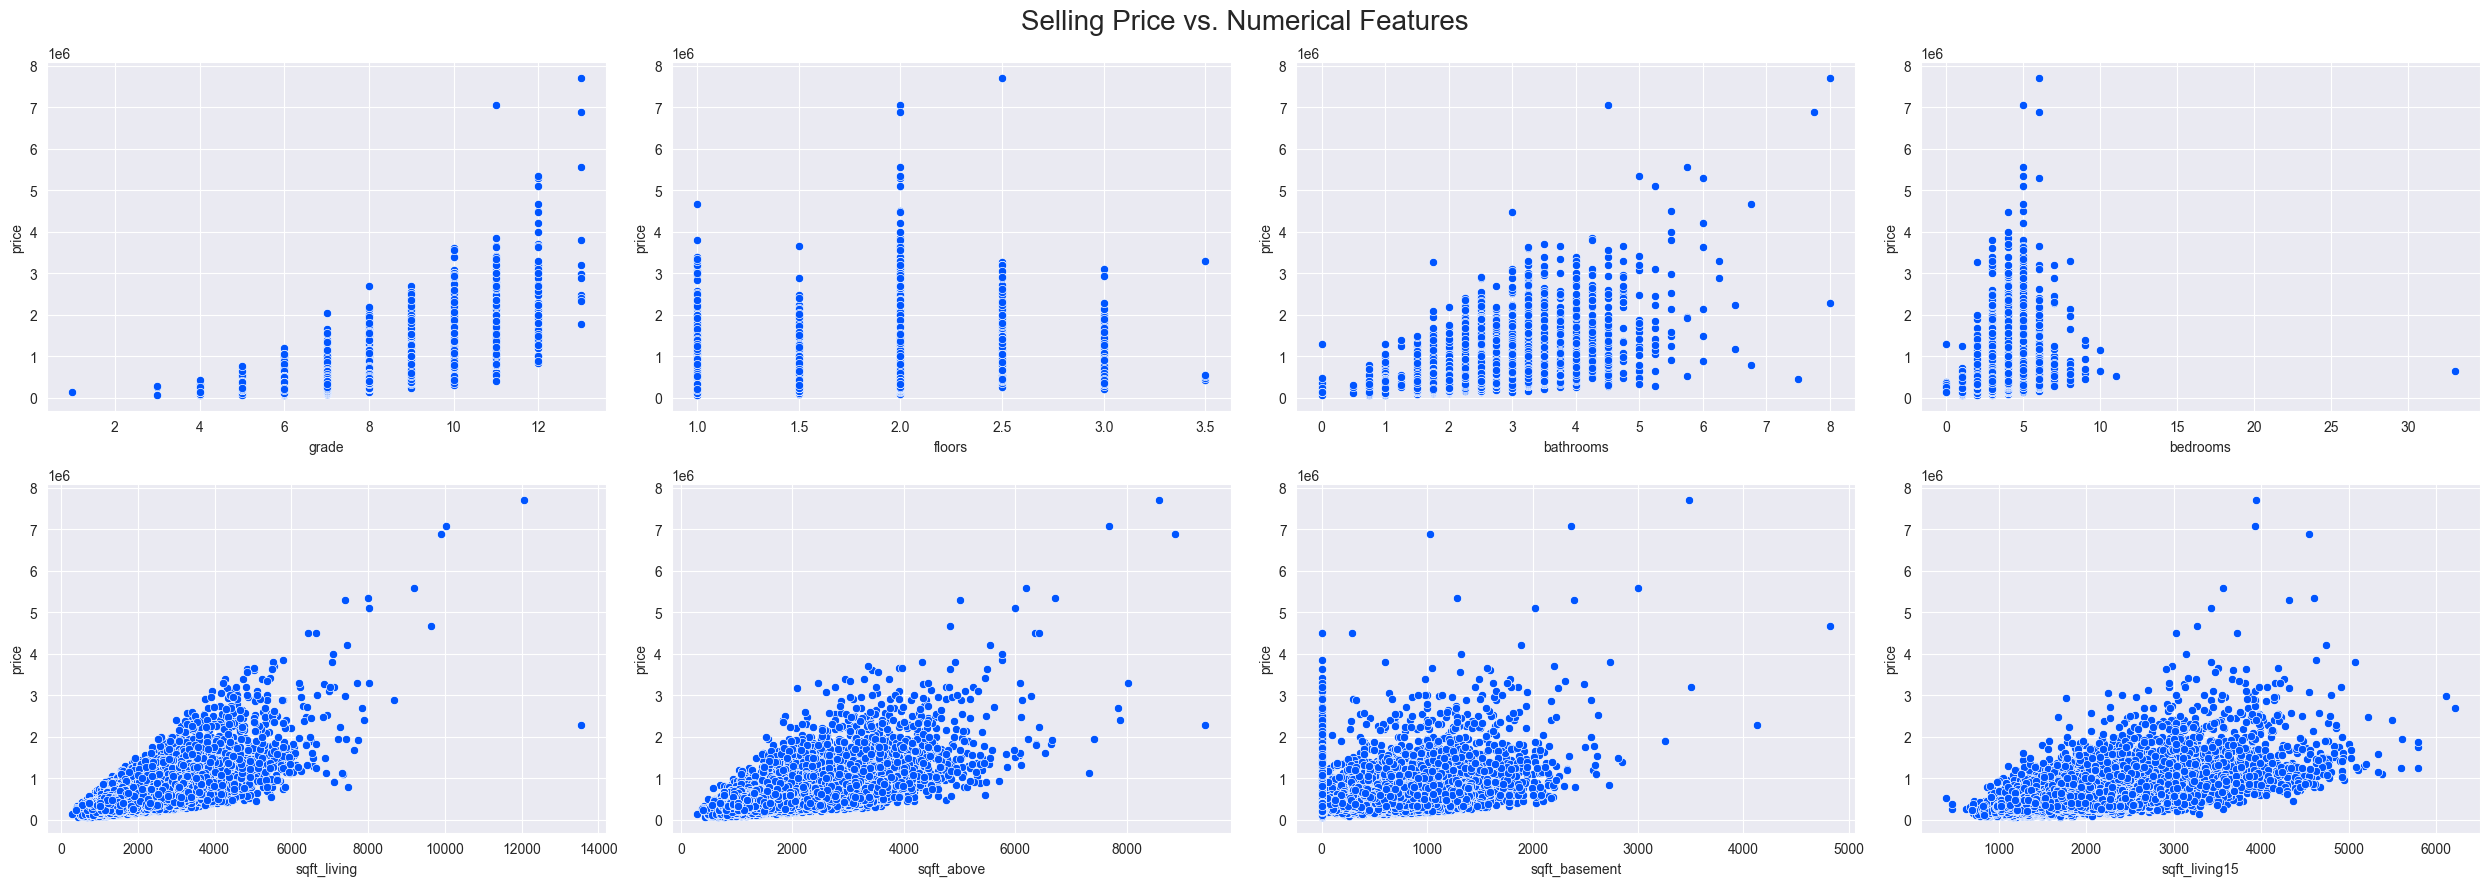

In [82]:
fig, axs = plt.subplots(2, len(numerical_columns) // 2, figsize=(25, 9))
for i, column in enumerate(numerical_columns):
    row = int(i / 4)
    col = i % 4
    sns.scatterplot(df, x=column, y="price", ax=axs[row, col])
plt.suptitle('Selling Price vs. Numerical Features', size=20)
plt.tight_layout()
plt.show()

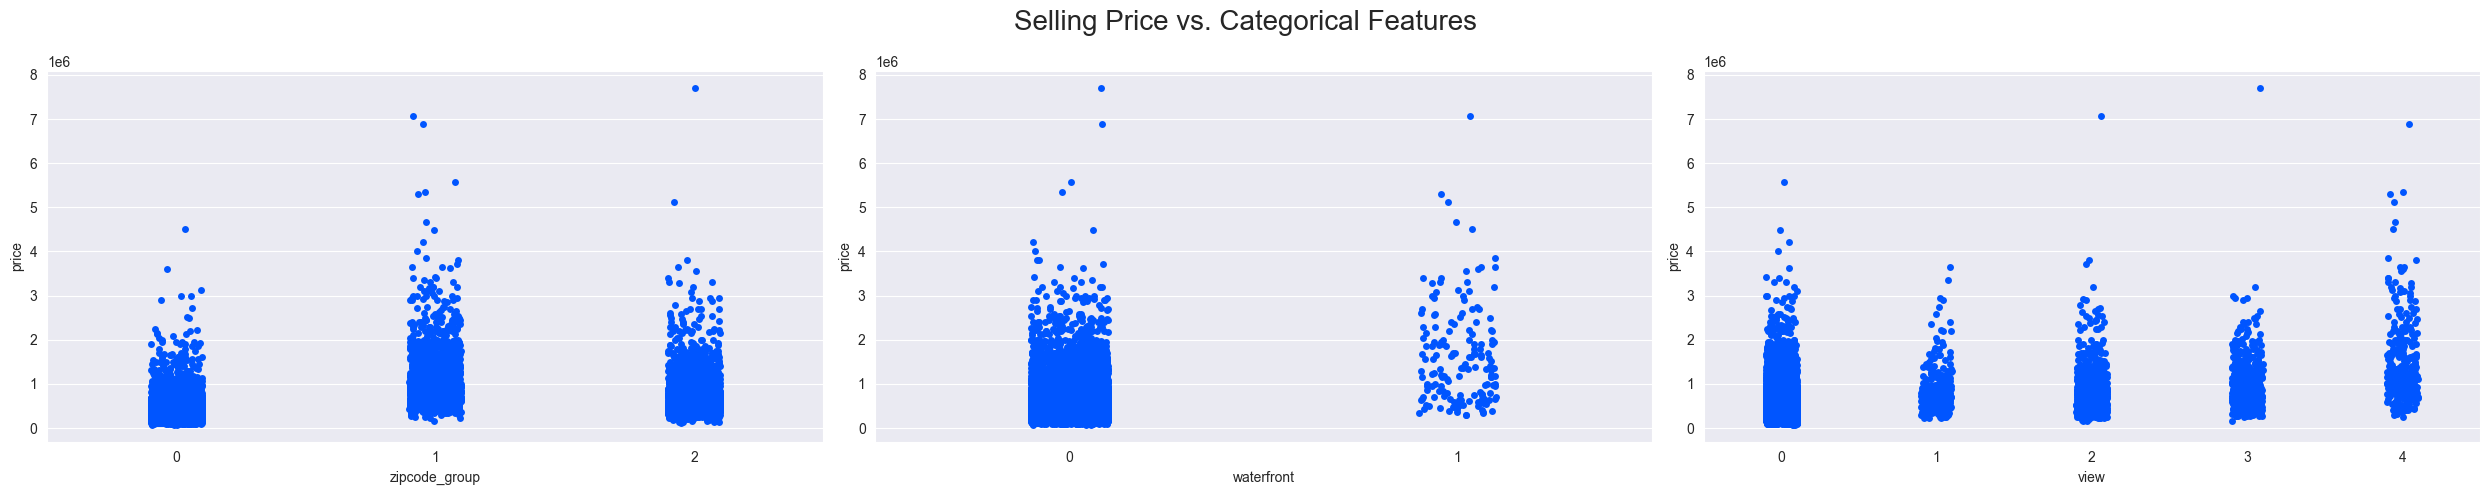

In [83]:
fig, axs = plt.subplots(1, len(categorical_columns), figsize=(25, 5))
for i, column in enumerate(categorical_columns):
    sns.stripplot(df, x=column, ax=axs[i], y="price")
plt.suptitle('Selling Price vs. Categorical Features', size=20)
plt.tight_layout()
plt.show()

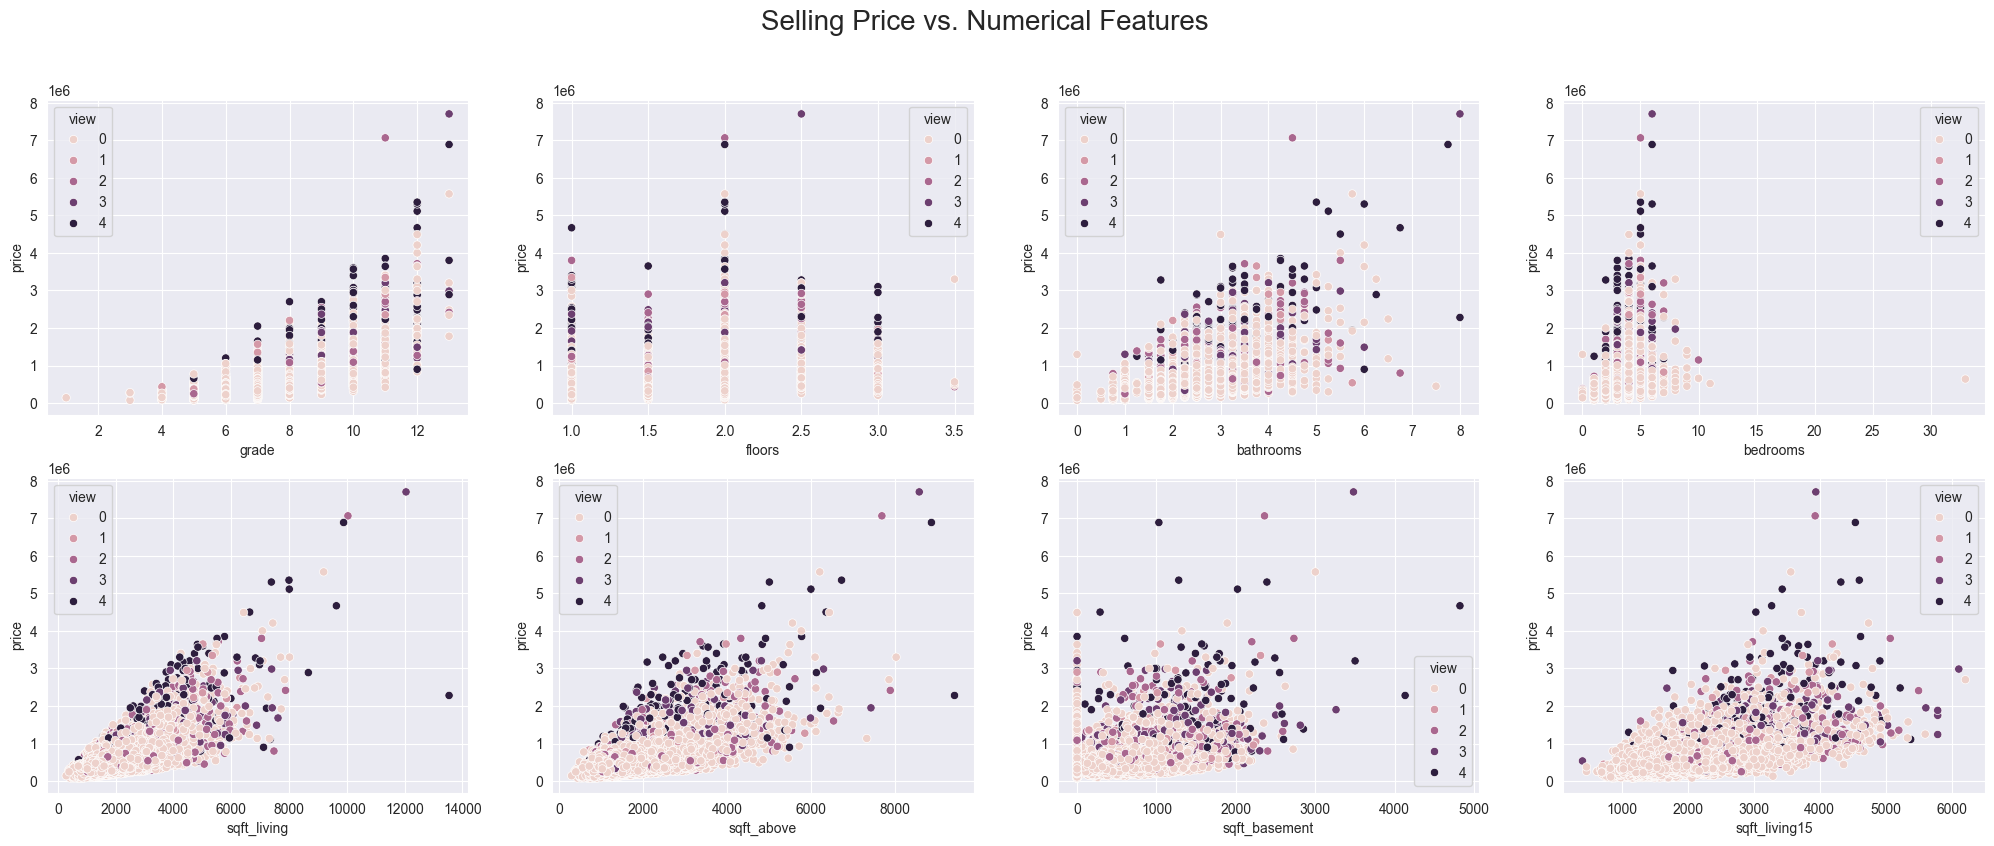

In [84]:
fig, axs = plt.subplots(2, len(numerical_columns) // 2, figsize=(25, 9))
for i, column in enumerate(numerical_columns):
    row = int(i / 4)
    col = i % 4
    sns.scatterplot(df, x=column, y="price", ax=axs[row, col], hue="view")
plt.suptitle('Selling Price vs. Numerical Features', size=20)
plt.show()

## Prepare data

In [85]:
df2 = df.with_columns(df[list(categorical_columns)].to_dummies()).drop(list(categorical_columns))
df2

shape: (21_013, 19)
┌──────────┬───────────┬─────────────┬────────┬───┬────────┬────────┬────────┬────────┐
│ bedrooms ┆ bathrooms ┆ sqft_living ┆ floors ┆ … ┆ view_1 ┆ view_2 ┆ view_3 ┆ view_4 │
│ ---      ┆ ---       ┆ ---         ┆ ---    ┆   ┆ ---    ┆ ---    ┆ ---    ┆ ---    │
│ i64      ┆ f64       ┆ i64         ┆ f64    ┆   ┆ u8     ┆ u8     ┆ u8     ┆ u8     │
╞══════════╪═══════════╪═════════════╪════════╪═══╪════════╪════════╪════════╪════════╡
│ 3        ┆ 1.0       ┆ 1180        ┆ 1.0    ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ 3        ┆ 2.25      ┆ 2570        ┆ 2.0    ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ 2        ┆ 1.0       ┆ 770         ┆ 1.0    ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ 4        ┆ 3.0       ┆ 1960        ┆ 1.0    ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ 3        ┆ 2.0       ┆ 1680        ┆ 1.0    ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ …        ┆ …         ┆ …           ┆ …      ┆ … ┆ …      ┆ …      ┆ …      ┆ …      │
│ 3        ┆ 2.5       ┆ 1530        ┆ 3.0    ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ 4        ┆ 2.5       ┆ 2310        ┆ 2.0    ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ 2        ┆ 0.75      ┆ 1020        ┆ 2.0    ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ 3        ┆ 2.5       ┆ 1600        ┆ 2.0    ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
│ 2        ┆ 0.75      ┆ 1020        ┆ 2.0    ┆ … ┆ 0      ┆ 0      ┆ 0      ┆ 0      │
└──────────┴───────────┴─────────────┴────────┴───┴────────┴────────┴────────┴────────┘

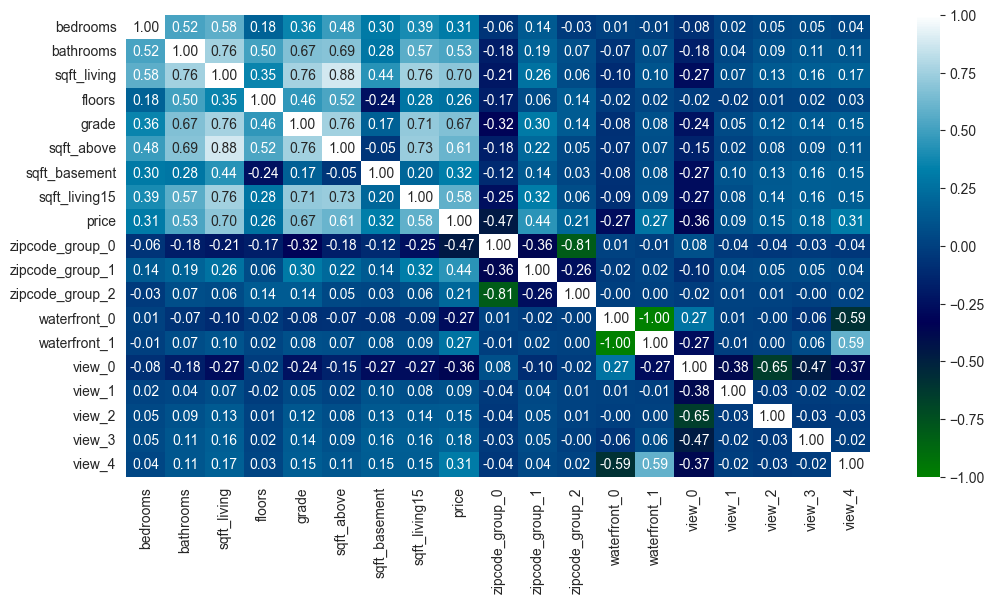

In [86]:
correlation = df2.corr()
# ax = sns.heatmap(pd.concat([df1.drop(target,axis=1), df1[target]],axis=1).corr(), annot=True, cmap=cmap)

plt.figure(figsize=(12, 6))
sns.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, cmap="ocean", annot=True,
            fmt=".2f")

plt.show()

In [87]:
X = df2.drop("price")
y = df2["price"]

In [88]:
X.shape, y.shape

((21013, 18), (21013,))

## Split train and test data

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

## Preprocess Data 

It is very important that Standard**Scaler** transformation **should only be learnt** from the **training set**, otherwise it will lead to data leakage.

### Cox-box transformation

The Box-Cox transformations change the shape of our data, making it more close to a normal distribution.

In order to prevent data leakage, the fitted lambda value for each feature is obtained from the training data set and then the transformation is applied to both training and test data:

In [90]:
type(X_train)

polars.dataframe.frame.DataFrame

In [91]:
fitted_lambda = {}
y_train, fitted_lambda["price"] = stats.boxcox(y_train + 1)
for col in X_train.columns:
    x, fitted_lambda[col] = stats.boxcox(X_train[col] + 1)
    X_train = X_train.with_columns(pl.Series(col, x))

In [92]:
for i, (k, v) in enumerate(fitted_lambda.items()):
    to_show = f"{k}: {v:.4f}"
    if i % 2:
        print(to_show)
    else:
        print(to_show, end=", ")


price: -0.2294, bedrooms: 0.3366
bathrooms: 0.3782, sqft_living: 0.0360
floors: -1.4672, grade: -0.5007
sqft_above: -0.2301, sqft_basement: -0.2109
sqft_living15: -0.2116, zipcode_group_0: 0.5627
zipcode_group_1: -13.8970, zipcode_group_2: -2.4703
waterfront_0: 192.4738, waterfront_1: -192.4738
view_0: 14.7822, view_1: -90.4914
view_2: -32.5090, view_3: -64.1579
view_4: -97.7891, 

### Transform testing data

In [93]:
y_test = stats.boxcox(y_test + 1, fitted_lambda['price'])
for col in X_test.columns:
    X_test = X_test.with_columns(pl.Series(col, stats.boxcox(X_test[col] + 1, fitted_lambda[col])))

In [94]:
y_train = pl.DataFrame({"price": y_train})
y_test = pl.DataFrame({"price": y_test})

## Visualizing transformations

In [95]:
X_boxcox = pl.concat([X_train, X_test])
y_boxcox = pl.concat([y_train, y_test])
df_boxcox = pl.concat([X_boxcox, y_boxcox], how="horizontal")

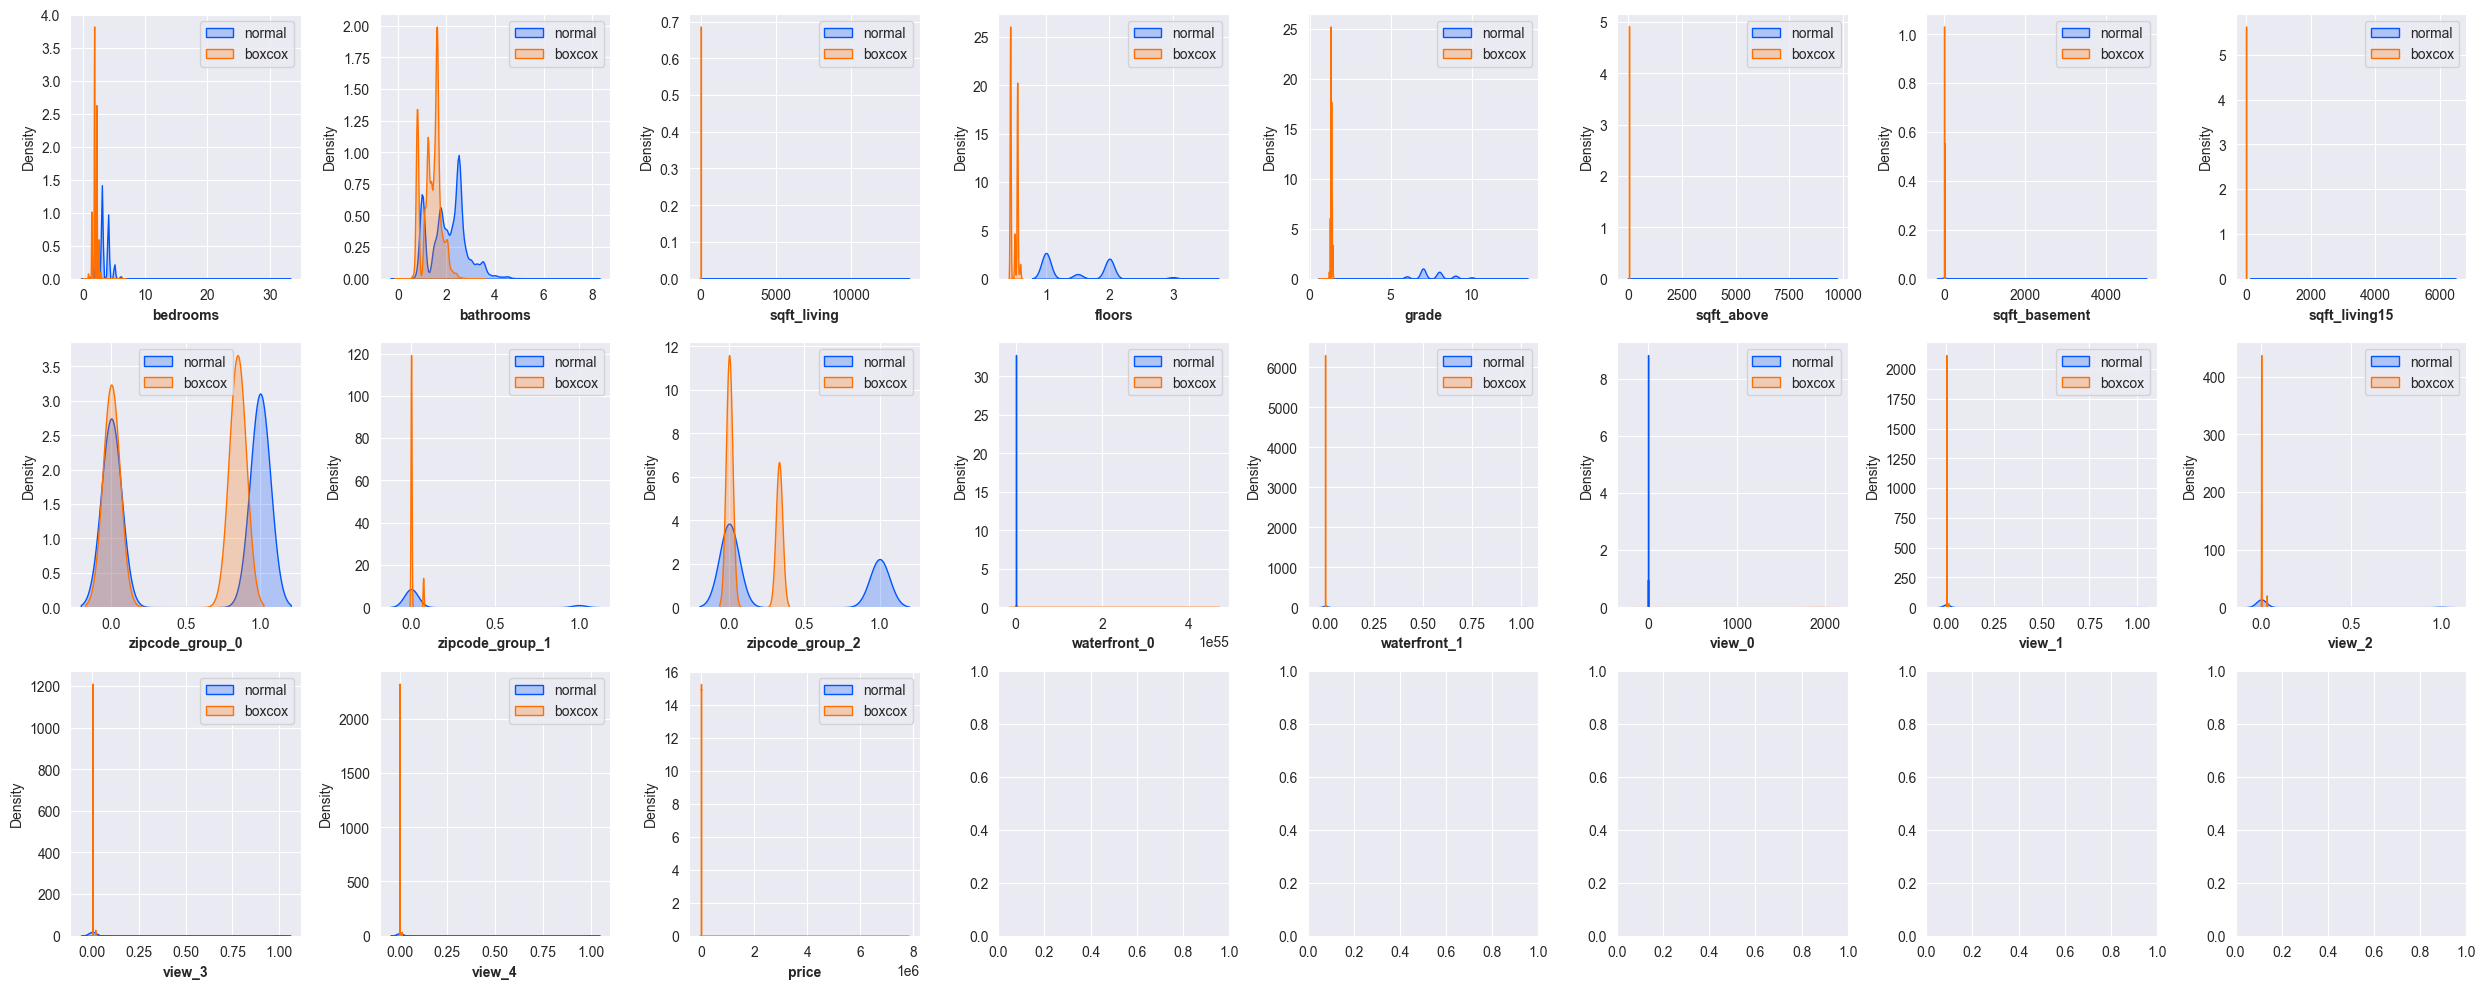

In [96]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))
for i, column in enumerate(df_boxcox.columns):
    row = int(i / 8)
    col = i % 8
    sns.kdeplot(df2, x=column, ax=axs[row, col], label="normal", fill=True)
    sns.kdeplot(df_boxcox, x=column, ax=axs[row, col], label="boxcox", fill=True)
    axs[row, col].set_xlabel(column, fontweight='bold')
    axs[row, col].legend()
plt.tight_layout()

In [97]:
X = df_boxcox.drop("price")
y = df_boxcox["price"]

## Preprocessing for polynomial features

In [98]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
# poly_features = PolynomialFeatures(degree=2)
# X_poly = poly_features.fit_transform(X)
# X_poly = pl.DataFrame(X_poly)
# X_poly.columns = poly_features.get_feature_names_out(X.columns)
X_poly = pl.DataFrame(poly_features.fit_transform(X), schema=list(poly_features.get_feature_names_out(X.columns)))
poly_features_names = X_poly.columns
X_poly.head(5)

shape: (5, 189)
┌──────────┬───────────┬─────────────┬──────────┬───┬────────┬──────────┬────────┬──────────┐
│ bedrooms ┆ bathrooms ┆ sqft_living ┆ floors   ┆ … ┆ view_2 ┆ view_3^2 ┆ view_3 ┆ view_4^2 │
│ ---      ┆ ---       ┆ ---         ┆ ---      ┆   ┆ view_4 ┆ ---      ┆ view_4 ┆ ---      │
│ f64      ┆ f64       ┆ f64         ┆ f64      ┆   ┆ ---    ┆ f64      ┆ ---    ┆ f64      │
│          ┆           ┆             ┆          ┆   ┆ f64    ┆          ┆ f64    ┆          │
╞══════════╪═══════════╪═════════════╪══════════╪═══╪════════╪══════════╪════════╪══════════╡
│ 1.329248 ┆ 1.232345  ┆ 8.574248    ┆ 0.435056 ┆ … ┆ 0.0    ┆ 0.0      ┆ 0.0    ┆ 0.0      │
│ 2.459168 ┆ 2.394191  ┆ 9.878946    ┆ 0.545586 ┆ … ┆ 0.0    ┆ 0.0      ┆ 0.0    ┆ 0.0      │
│ 1.766455 ┆ 1.362033  ┆ 8.741791    ┆ 0.435056 ┆ … ┆ 0.0    ┆ 0.0      ┆ 0.0    ┆ 0.0      │
│ 2.135964 ┆ 1.602532  ┆ 8.67447     ┆ 0.545586 ┆ … ┆ 0.0    ┆ 0.0      ┆ 0.0    ┆ 0.0      │
│ 1.766455 ┆ 1.485161  ┆ 8.618108    ┆ 0.435056 ┆ … ┆ 0.0    ┆ 0.0      ┆ 0.0    ┆ 0.0      │
└──────────┴───────────┴─────────────┴──────────┴───┴────────┴──────────┴────────┴──────────┘

## Splitting data

In [99]:
X_poly_train, X_poly_test, y_poly_train, y_poly_test = train_test_split(X_poly, y, test_size=0.3, random_state=0)
print('X_poly_train shape: ', X_poly_train.shape)
print('X_poly_test shape: ', X_poly_test.shape)
print('y_poly_train shape: ', y_poly_train.shape)
print('y_poly_test shape: ', y_poly_test.shape)

X_poly_train shape:  (14709, 189)
X_poly_test shape:  (6304, 189)
y_poly_train shape:  (14709,)
y_poly_test shape:  (6304,)


In [100]:
scaler = StandardScaler()
scaler.fit(X_poly_train)

X_poly_train = scaler.transform(X_poly_train)
X_poly_train = pl.DataFrame(X_poly_train, schema=poly_features_names)

X_poly_test = scaler.transform(X_poly_test)
X_poly_test = pl.DataFrame(X_poly_test, schema=poly_features_names)

## Create Polynomial Regression Model using Linear Regression

In [101]:
reg = LinearRegression()
model = reg.fit(X_poly_train, y_poly_train)

In [102]:
model.coef_, model.intercept_

(array([-2.59866128e-02,  5.81290464e-02,  3.47475003e-01,  2.67292361e-02,
         3.60453159e-02, -4.35464441e-01, -9.40544715e-02, -6.37631437e-02,
        -3.85972018e-03, -1.10909720e-02,  1.09652629e-02,  3.38912347e-03,
        -3.38912347e-03,  5.80599082e-03, -6.13743100e-03, -4.38637802e-03,
         3.29217650e-03, -4.70870899e-03,  8.77548270e-04, -1.79399994e-03,
        -3.10715429e-02,  1.00193258e-02, -1.18049497e-02,  6.24211512e-02,
         3.57593488e-03,  1.99351188e-02, -6.16089926e-03, -2.95638805e-03,
        -1.30279793e-03, -2.09749491e-02, -7.30248609e-03, -7.28128346e-03,
        -2.28256178e-03, -4.62714323e-03, -3.70295844e-03, -2.96282419e-03,
         3.84608656e-03,  7.86622519e-02, -1.58406712e-02, -6.02680722e-04,
        -1.40632782e-01, -6.90046089e-03, -5.26335363e-02,  1.30011607e-02,
         8.16548387e-03,  1.22267178e-02,  5.02844067e-02,  1.70087045e-02,
         2.27778954e-02,  7.08494598e-03,  1.35739656e-02,  9.28007695e-03,
         8.5

## Evaluate the model

In [103]:
y_pred = model.predict(X_poly_test)
mae = mean_absolute_error(y_true=y_poly_test, y_pred=y_pred)
mse = mean_squared_error(y_true=y_poly_test, y_pred=y_pred)
rmse = root_mean_squared_error(y_true=y_poly_test, y_pred=y_pred)
mse = mean_squared_error(y_poly_test, y_pred)
r2 = r2_score(y_poly_test, y_pred)

print('MAE: {} MSE: {} RMSE: {} R^2 {}'.format(mae, mse, rmse, r2))

MAE: 0.010176626602225453 MSE: 0.00016845456585078564 RMSE: 0.012979004809721955 R^2 0.751455159950092


## Visualize your result

Text(0, 0.5, 'y-actual')

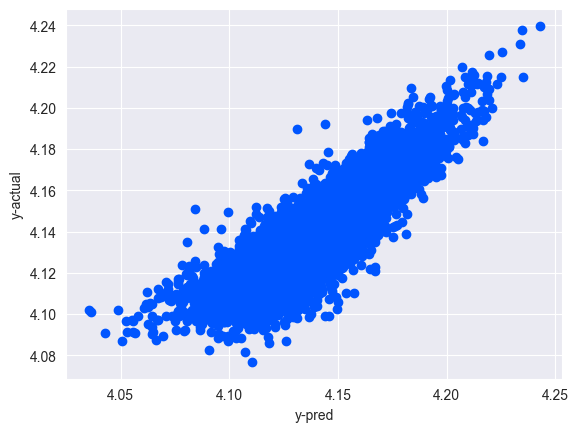

In [104]:
plt.scatter(y_poly_test, y_pred)
plt.xlabel('y-pred')
plt.ylabel('y-actual')

In [105]:
def residuals(model_: LinearRegression, X_test_, y_test_):
    """
    Creates predictions on the features with the model and calculates residuals
    """
    y_pred_ = model_.predict(X_test_)
    df_results = pl.DataFrame({'Predicted': y_pred_})
    df_results = df_results.with_columns(y_test_.alias("Actual"))
    return df_results.with_columns((df_results['Actual'] - df_results['Predicted']).abs().alias("Residuals"))

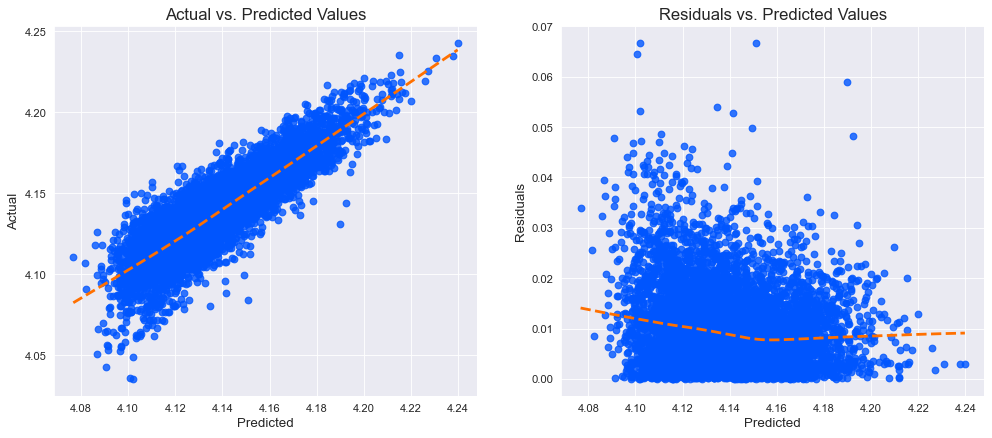

In [106]:
def linear_assumption(model_: LinearRegression, X_test_, y_test_):
    """
    Function for visually inspecting the assumption of linearity in a linear regression model
    """
    
    df_results = residuals(model_, X_test_, y_test_)

    fig, ax = plt.subplots(1, 2, figsize=(15, 6), dpi=80)
    sns.regplot(x='Predicted', y='Actual', data=df_results, lowess=True, ax=ax[0],
                color='#0055ff', line_kws={'color': '#ff7000', 'ls': '--', 'lw': 2.5})
    
    ax[0].set_title('Actual vs. Predicted Values', fontsize=15)
    ax[0].set_xlabel('Predicted', fontsize=12)
    ax[0].set_ylabel('Actual', fontsize=12)

    sns.regplot(x='Predicted', y='Residuals', data=df_results, lowess=True, ax=ax[1],
                color='#0055ff', line_kws={'color': '#ff7000', 'ls': '--', 'lw': 2.5})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=15)
    ax[1].set_xlabel('Predicted', fontsize=12)
    ax[1].set_ylabel('Residuals', fontsize=12)


linear_assumption(model, X_poly_test, y_poly_test)

In [107]:
def normal_errors_assumption(model_, X_test_, y_test_, p_value_thresh=0.05):
    """
    Function for inspecting the assumption of normality of residuals.
    """
    df_results = residuals(model_, X_test_, y_test_)

    # Anderson-Darling Test
    p_value = normal_ad(df_results['Residuals'])[1]

    print('\nP-value from the test (below 0.05 generally means non-normal):  ', np.round(p_value,6))
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed. Assumption not satisfied.')
    else:
        print('Residuals are normally distributed. Assumption satisfied.')


    # Residuals Histogram
    fig, ax = plt.subplots(1,2, figsize=(15,6), dpi=80)

    sns.histplot(data=df_results, x='Residuals', kde=True, ax=ax[0], bins=15,
                 color='#0055ff', edgecolor='none', alpha=0.4, line_kws={'lw': 2.5})
    ax[0].set_xlabel('Residuals', fontsize=12)
    ax[0].set_ylabel('Count', fontsize=12)
    ax[0].set_title('Distribution of Residuals', fontsize=15)
    textstr = '\n'.join((
        r'$\mu=%.2f$' %df_results['Residuals'].mean(),
        r'$\sigma=%.2f$' %df_results['Residuals'].std(),
    ))
    ax[0].text(0.7, 0.9, textstr, transform=ax[0].transAxes, fontsize=15, verticalalignment='top',
               bbox=dict(boxstyle='round',facecolor='#509aff', edgecolor='black', pad=0.5))


    # Q-Q Probability Plot
    stats.probplot(df_results['Residuals'], dist="norm", plot= ax[1])
    ax[1].set_title("Residuals Q-Q Plot", fontsize=15)
    ax[1].set_xlabel('Theoretical Quantiles', fontsize=12)
    ax[1].set_ylabel('Ordered Values', fontsize=12)
    ax[1].get_lines()[0].set_markerfacecolor('#509aff')
    ax[1].get_lines()[1].set_color('#ff7000')
    ax[1].get_lines()[1].set_linewidth(2.5)
    ax[1].get_lines()[1].set_linestyle('--')
    ax[1].legend(['Actual','Theoretical'])

    plt.show()


P-value from the test (below 0.05 generally means non-normal):   0.0
Residuals are not normally distributed. Assumption not satisfied.


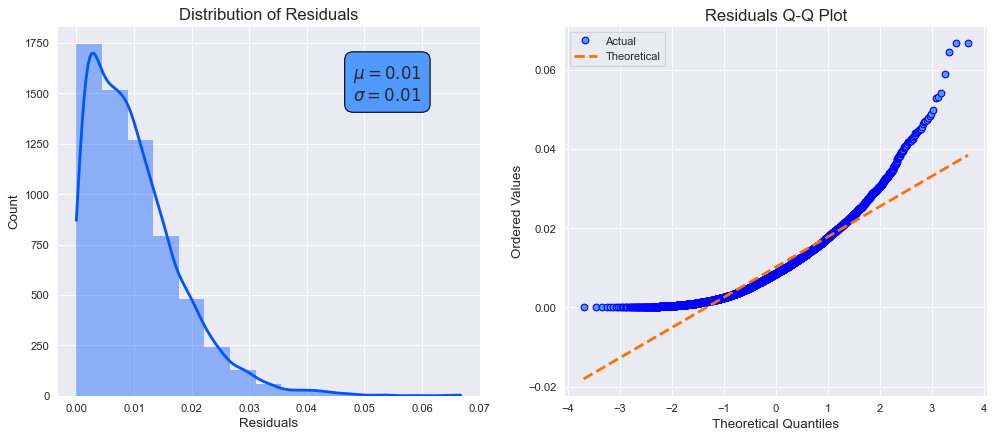

In [108]:
normal_errors_assumption(model, X_poly_test, y_poly_test)

[see this for more information](https://www.kaggle.com/code/farzadnekouei/polynomial-regression-regularization-assumptions#Step-10.4:-Create-Polynomial-Regression-Model-using-Linear-Regression)